# CS4035 - Cyber Data Analytics
## Lab 3 

# --- NOTES ---

- Discretize each "netflow" (which is just a single packet/row)
- For each feature, create "bins" for the values (nunique? LabelEncoder?) 
- Concatenate all of these bins into a single feature, such that the dataset only has one feature (confirm?)
- Use k-means to create clusters, and then "utilize the interaction between the features to come up with the features" (optional)


- [Student] "so each row has 1 feature after the concatenation. Since we need a 3-gram, doesn't this essentialy mean that we take row 1, row 2 and row 3 as the first 3-gram? Is then the second 3-gram, row 2, row 3, row 4?"
- [Daniel Vos] "Yes, essentially. You summarize each row with one number/symbol and take 3-grams of these numbers/symbols"

---
Week 7:

- Using a .random() value is equivalent to using a hash function for determining an index, if hashing is too slow. 
- MurmurHash is a non-cryptographic hash function library that is faster than a cryptographic hash library.


### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name: Srinath Jayaraman
### ID: 5049903

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

- Be sure to install the following: 
    - the python wrapper for murmurhash3: `pip install mmh3`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import mmh3
import re

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

In [2]:
df_10 = pd.read_csv("./dataset_10/capture20110818.binetflow")

# Drop the following columns because...
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)
df_10.head()

Dur Proto        SrcAddr  Sport    Dir         DstAddr Dport  \
0  3587.569824   tcp  147.32.84.164  54784    <?>  74.125.232.215   443   
1   198.072739   tcp  147.32.84.164  56165    <?>  74.125.232.197    80   
2   197.928329   tcp  147.32.84.164  57965    <?>  209.85.149.138    80   
3     0.000399   udp  147.32.84.170  45807    <->     147.32.80.9    53   
4     0.000400   udp  147.32.84.170  35380    <->     147.32.80.9    53   

   State  TotPkts  TotBytes  SrcBytes                          Label  
0  PA_PA     3049    978731    245317     flow=From-Normal-V51-Grill  
1  FA_FA       14       924       462     flow=From-Normal-V51-Grill  
2  FA_FA       14       924       462     flow=From-Normal-V51-Grill  
3    CON        2       400        74  flow=From-Normal-V51-Stribrek  
4    CON        2       400        74  flow=From-Normal-V51-Stribrek

In [3]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122199 entries, 0 to 122198
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Dur       122199 non-null  float64
 1   Proto     122199 non-null  object 
 2   SrcAddr   122199 non-null  object 
 3   Sport     122172 non-null  object 
 4   Dir       122199 non-null  object 
 5   DstAddr   122199 non-null  object 
 6   Dport     21003 non-null   object 
 7   State     120972 non-null  object 
 8   TotPkts   122199 non-null  int64  
 9   TotBytes  122199 non-null  int64  
 10  SrcBytes  122199 non-null  int64  
 11  Label     122199 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 11.2+ MB


## 1. Familiarization and discretization task – 1 A4

In [4]:
# First let's see what kind of null values we've got
df_10.isnull().sum()

Dur              0
Proto            0
SrcAddr          0
Sport           27
Dir              0
DstAddr          0
Dport       101196
State         1227
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

In [5]:
# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER

In [6]:
# Remove hexadecimal values from the dataset
df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')

df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))

df_10.Dport

0           443
1            80
2            80
3            53
4            53
          ...  
122194    33822
122195    33822
122196       53
122197       53
122198       80
Name: Dport, Length: 122199, dtype: int64

In [7]:
# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
# df_10_inf.Metalabel.loc[np.where(df_10_inf.Label.str.contains('Normal'))] = 'Normal'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'

df_10


<ipython-input-7-bce7a68da95d>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Dur Proto        SrcAddr  Sport    Dir         DstAddr  Dport  \
0       3587.569824   tcp  147.32.84.164  54784    <?>  74.125.232.215    443   
1        198.072739   tcp  147.32.84.164  56165    <?>  74.125.232.197     80   
2        197.928329   tcp  147.32.84.164  57965    <?>  209.85.149.138     80   
3          0.000399   udp  147.32.84.170  45807    <->     147.32.80.9     53   
4          0.000400   udp  147.32.84.170  35380    <->     147.32.80.9     53   
...             ...   ...            ...    ...    ...             ...    ...   
122194     0.000743  icmp  147.32.84.164      8    <->    147.32.96.69  33822   
122195     0.000913  icmp  147.32.84.164      8    <->    147.32.96.69  33822   
122196     0.000414   udp  147.32.84.170  37138    <->     147.32.80.9     53   
122197     0.000322   udp  147.32.84.170  39771    <->     147.32.80.9     53   
122198     0.109055   tcp  147.32.84.170  43073     ->  195.24.232.205     80   

         State  TotPkts  TotBytes  SrcBytes                          Label  \
0        PA_PA     3049    978731    245317     flow=From-Normal-V51-Grill   
1        FA_FA       14       924       462     flow=From-Normal-V51-Grill   
2        FA_FA       14       924       462     flow=From-Normal-V51-Grill   
3          CON        2       400        74  flow=From-Normal-V51-Stribrek   
4          CON        2       400        74  flow=From-Normal-V51-Stribrek   
...        ...      ...       ...       ...                            ...   
122194     ECO        2       196        98     flow=From-Normal-V51-Grill   
122195     ECO        2       196        98     flow=From-Normal-V51-Grill   
122196     CON        2       244        81  flow=From-Normal-V51-Stribrek   
122197     CON        2       280        81  flow=From-Normal-V51-Stribrek   
122198  SPA_SA        5       557       417  flow=From-Normal-V51-Stribrek   

       MetaLabel  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
122194       NaN  
122195       NaN  
122196       NaN  
122197       NaN  
122198       NaN  

[122199 rows x 13 columns]

In [8]:
# Identify the infected hosts:
inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].SrcAddr.unique()
inf

array(['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
       '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207',
       '147.32.84.208', '147.32.84.209'], dtype=object)

In [9]:
# see the activity level of each infected host
df_10.SrcAddr.loc[np.where(df_10.Label.str.contains('Botnet'))].value_counts()

147.32.84.205    11874
147.32.84.206    11287
147.32.84.204    11159
147.32.84.208    11118
147.32.84.207    10581
147.32.84.191    10454
147.32.84.192    10397
147.32.84.193    10009
147.32.84.209     9894
147.32.84.165     9579
Name: SrcAddr, dtype: int64

<BarContainer object of 10 artists>

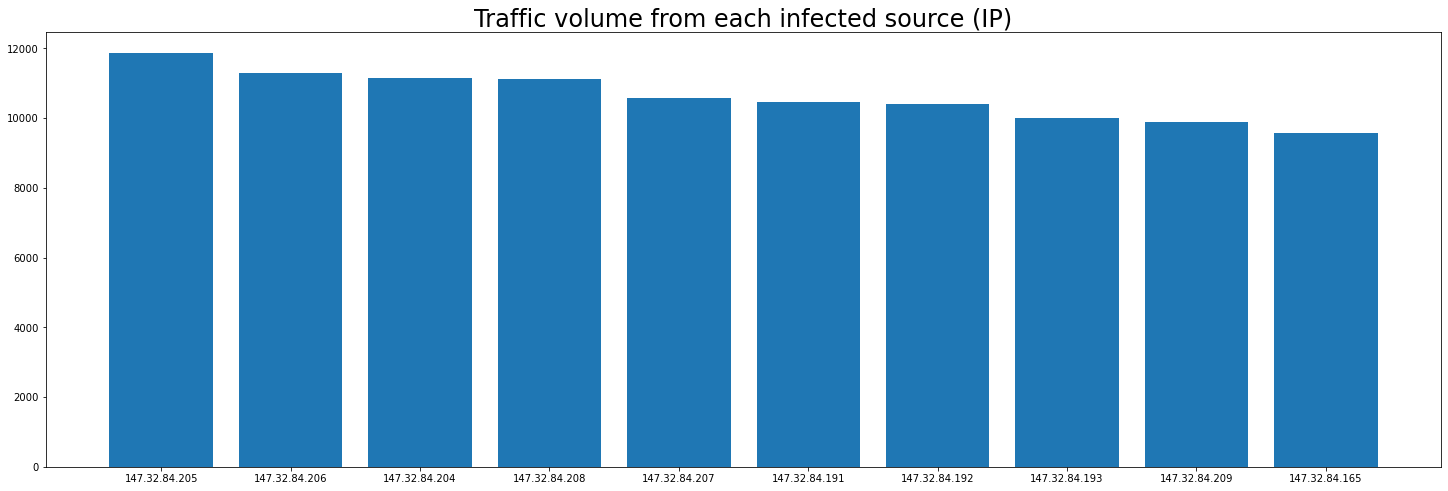

In [10]:
# visualization of amount of traffic from each infected source
fig = plt.figure(figsize=(25,8))
plt.title('Traffic volume from each infected source (IP)', size=24)
plt.bar(df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts().index,
        df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts())

In [11]:
# pick one of the hosts (we'll choose the one with the most traffic)
df_10_inf_1 = df_10.loc[df_10.SrcAddr == '147.32.84.205'].reset_index(inplace=False)
df_10_inf_1

index         Dur Proto        SrcAddr  Sport    Dir          DstAddr  \
0        1473    0.000263   udp  147.32.84.205   1025    <->      147.32.80.9   
1        1474    0.000401   udp  147.32.84.205   1025    <->      147.32.80.9   
2        1475    0.075763   tcp  147.32.84.205   1027     ->   74.125.232.199   
3        1478    0.000450   udp  147.32.84.205   1025    <->      147.32.80.9   
4        1479    3.017135   udp  147.32.84.205    123     ->      65.55.56.40   
...       ...         ...   ...            ...    ...    ...              ...   
11869  121650  367.653198   tcp  147.32.84.205   1026     ->  216.155.130.130   
11870  121654    0.000455   udp  147.32.84.205   1025    <->      147.32.80.9   
11871  121655    0.044163   tcp  147.32.84.205   1028     ->   74.125.232.202   
11872  121656    0.000412   udp  147.32.84.205   1025    <->      147.32.80.9   
11873  121657    2.994376   udp  147.32.84.205    123     ->      65.55.56.40   

       Dport     State  TotPkts  TotBytes  SrcBytes  \
0         53       CON        2       203        64   
1         53       CON        2       590        87   
2         80  SRPA_SPA        7       882       629   
3         53       CON        2       479        76   
4        123       INT        2       180       180   
...      ...       ...      ...       ...       ...   
11869   6667   SPA_SPA       55     14273      1662   
11870     53       CON        2       590        87   
11871     80  SRPA_SPA        7       882       629   
11872     53       CON        2       479        76   
11873    123       INT        2       180       180   

                                                   Label   MetaLabel  
0                         flow=From-Botnet-V51-6-UDP-DNS  Botnet-UDP  
1                         flow=From-Botnet-V51-6-UDP-DNS  Botnet-UDP  
2      flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...  Botnet-TCP  
3                         flow=From-Botnet-V51-6-UDP-DNS  Botnet-UDP  
4                     flow=From-Botnet-V51-6-UDP-Attempt  Botnet-UDP  
...                                                  ...         ...  
11869  flow=From-Botnet-V51-6-TCP-CC106-IRC-Not-Encry...  Botnet-TCP  
11870                     flow=From-Botnet-V51-6-UDP-DNS  Botnet-UDP  
11871  flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...  Botnet-TCP  
11872                     flow=From-Botnet-V51-6-UDP-DNS  Botnet-UDP  
11873                 flow=From-Botnet-V51-6-UDP-Attempt  Botnet-UDP  

[11874 rows x 14 columns]

In [12]:
df_10_inf_1.Proto.value_counts()

icmp    11836
udp        30
tcp         8
Name: Proto, dtype: int64

<BarContainer object of 3 artists>

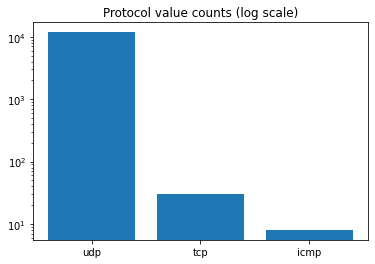

In [13]:
# Let's see what the frequency of each type of packet is
plt.yscale('log')
plt.title('Protocol value counts (log scale)')
plt.bar(df_10_inf_1.Proto.unique(), df_10_inf_1.Proto.value_counts())

<BarContainer object of 2 artists>

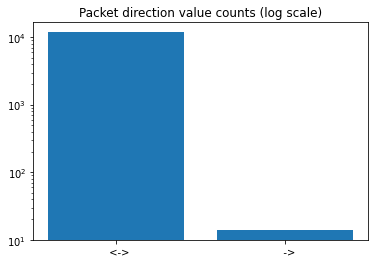

In [14]:
# frequency of each type of directional traffic
plt.yscale('log')
plt.title('Packet direction value counts (log scale)')
plt.bar(df_10_inf_1.Dir.unique(), df_10_inf_1.Dir.value_counts())

In [15]:
df_10_enc = df_10_inf_1.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)


In [16]:
print(df_10_enc.MetaLabel.value_counts().to_string())

Botnet-ICMP    11836
Botnet-UDP        30
Botnet-TCP         8


In [17]:
df_10_enc['EncLabel'] = pd.Series()
# df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('Normal'))] = 0
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3

df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')
df_10_enc.EncLabel

<ipython-input-17-36a56fe13de3>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0        2
1        2
2        3
3        2
4        2
        ..
11869    3
11870    2
11871    3
11872    2
11873    2
Name: EncLabel, Length: 11874, dtype: int8

In [18]:
# might not want to blindly encode these:
df_10_enc.Label = LabelEncoder().fit_transform(df_10_enc.Label)
print(df_10_enc.MetaLabel.value_counts())

Botnet-ICMP    11836
Botnet-UDP        30
Botnet-TCP         8
Name: MetaLabel, dtype: int64


In [19]:
df_10_enc.head(10)

index          Dur  Proto  SrcAddr  Sport  Dir  DstAddr  Dport  State  \
0   1473     0.000263      2        0     53    1        0    190      1   
1   1474     0.000401      2        0     53    1        0    190      1   
2   1475     0.075763      1        0     57    0        5    221     30   
3   1478     0.000450      2        0     53    1        0    190      1   
4   1479     3.017135      2        0    426    0        4     28      7   
5   1974     0.000465      2        0     53    1        0    190      1   
6   1975  3570.946045      1        0     68    0        9    205     28   
7   2492     0.000227      2        0     53    1        0    190      1   
8   2497     0.000384      2        0     53    1        0    190      1   
9   2498    60.004951      1        0     72    0        2    221     30   

   TotPkts  TotBytes  SrcBytes  Label   MetaLabel  EncLabel  
0        1         2         1      5  Botnet-UDP         2  
1        1         6         4      5  Botnet-UDP         2  
2        4         7         7      2  Botnet-TCP         3  
3        1         4         2      5  Botnet-UDP         2  
4        1         1         5      4  Botnet-UDP         2  
5        1         5         2      5  Botnet-UDP         2  
6       51        33        12      1  Botnet-TCP         3  
7        1         2         1      5  Botnet-UDP         2  
8        1         3         3      5  Botnet-UDP         2  
9        5         9         6      3  Botnet-TCP         3

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

Text(0.5, 1.0, 'Correlation heat map')

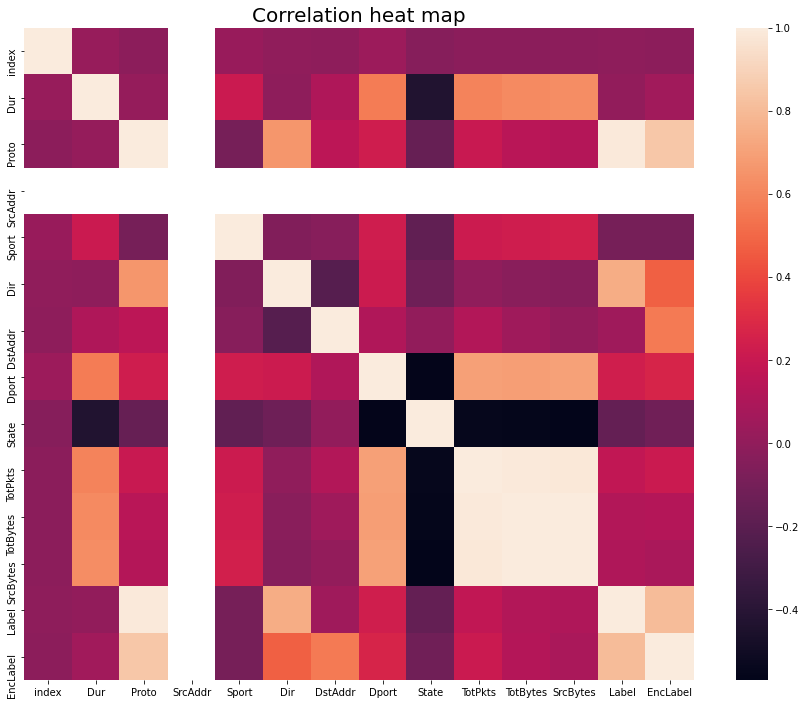

In [20]:
# Let's look at a correlation heatmap to see which are closely associated with target labels
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_10_enc.corr())
plt.title('Correlation heat map', size=20)

Text(0.5, 1.0, 'Direction (blue) vs. Attack Type (yellow)')

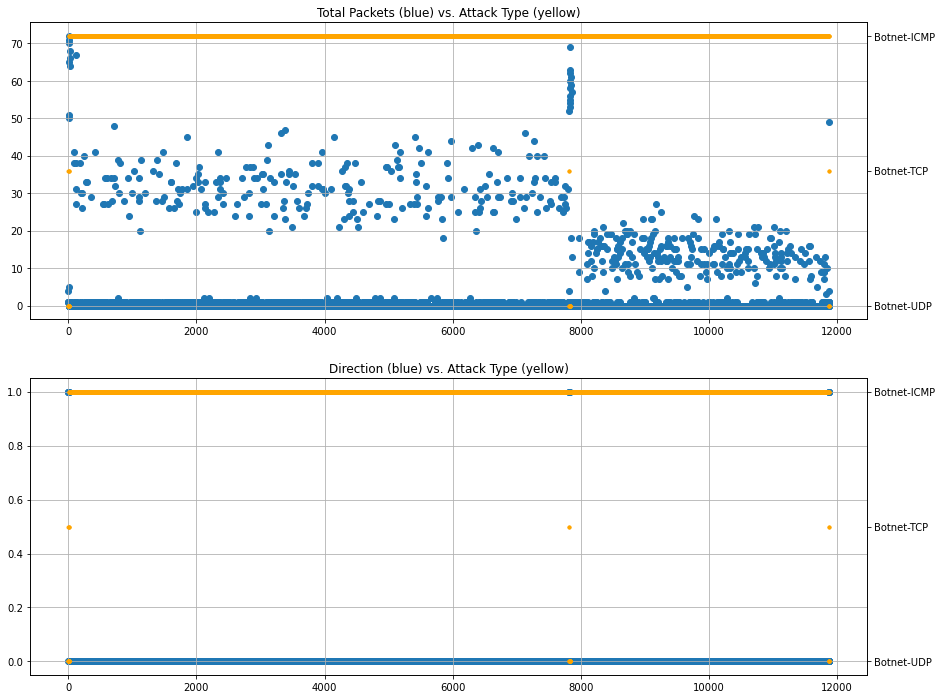

In [21]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))


ax1.scatter(df_10_enc.index, df_10_enc.TotPkts, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax1.scatter(df_10_enc.index, df_10_enc.TotBytes, marker=".", color='green', alpha=1)
# ax1.legend(['Dport'], loc='upper left')
# ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10_enc.index, df_10_enc.Dir, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax3.legend(['TotPkts'], loc='center left')
# ax4.legend(['Label'], loc='center right')

ax1.set_title('Total Packets (blue) vs. Attack Type (yellow)')
ax3.set_title('Direction (blue) vs. Attack Type (yellow)')



### 1b. Discretize selected features

As we see above, `Protocol` is most directly correlated with the encoded label. However, this is largely because `EncLabel` is a feature derived from `Protocol`, so we ignore it. Furthermore, the vast majority (>99%) of the values in `Proto` are `ICMP`, so the data is incredibly unbalanced.

The next highest correlation is `DstAddr`. Now, attackers can theoretically choose any target as a victim, so filtering destinations likely won't help us with a general model. 

Following that, the next highest correlation is `Dport`, but the vast majority of the dataset has been backfilled to `0` because most of the Dport values were `NaN`. This means that `Dir` and `TotPkts` are the next 2 most correlated features to the target labels.

Text(0.5, 1.0, 'Direction value counts (log scale)')

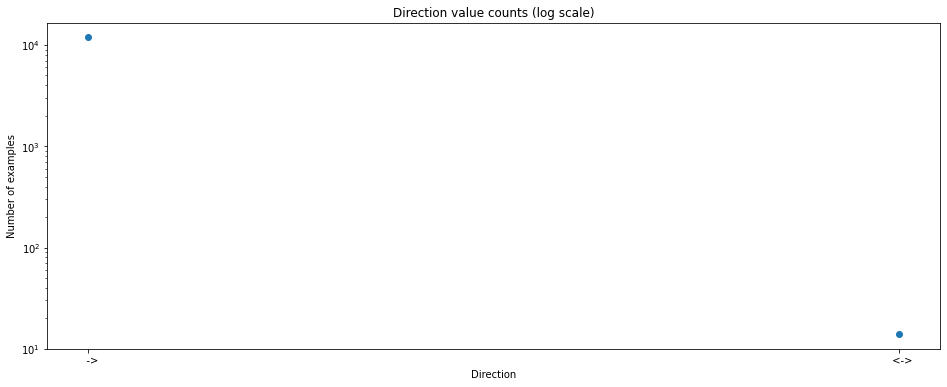

In [22]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# ax1 = plt.twinx()
plt.scatter(df_10_inf_1.Dir.value_counts().sort_index().index.values, df_10_inf_1.Dir.value_counts().sort_index())
# ax.scatter(df_10_enc.Dir.value_counts().sort_index().index.values, df_10_enc.Dir.value_counts().sort_index())
plt.ylabel('Number of examples')
plt.xlabel('Direction')
plt.title('Direction value counts (log scale)')

We see above that `DstAddr = 1` has far more attacks against it than any other port from this specific host.

Text(0.5, 1.0, 'Total number of packets value counts (log scale)')

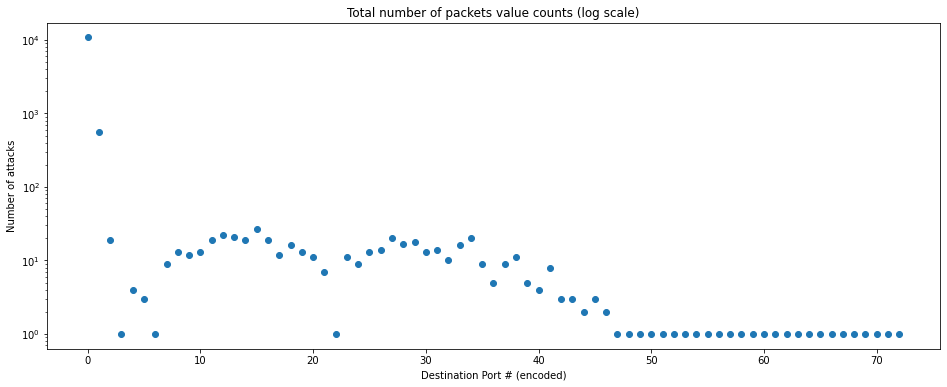

In [23]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# sorted_counts = np.sort(df_10_enc.Dport.value_counts().index)
plt.scatter(df_10_enc.TotPkts.value_counts().sort_index().index.values, df_10_enc.TotPkts.value_counts().sort_index())
plt.ylabel('Number of attacks')
plt.xlabel('Destination Port # (encoded)')
plt.title('Total number of packets value counts (log scale)')

Apply the discretization to the entire dataset:

In [24]:
# We can see that Dport and Dir are the two most outstanding features with the Metalabel w.r.t. botnet behavior
# Let's combine these with the encoded labels


df_10_inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_10_enc = df_10_inf.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3
df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')


df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_x = pd.concat([df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)

df_10_x.DTP.value_counts()

<ipython-input-24-720fa04a273d>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


00      96238
01       4697
011       218
012       197
09        194
        ...  
0152        1
063         1
0178        1
0144        1
054         1
Name: DTP, Length: 240, dtype: int64

In [25]:
# Let's bin the values into 3 categories:

# w = the most common value
w = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[0])])
z = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[1])])

y = df_10_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_10_x = pd.concat([w,x,y], sort=False).sort_index()
df_10_x

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


DTP    MetaLabel  EncLabel
0         3   Botnet-UDP         2
1         3   Botnet-UDP         2
2         3   Botnet-TCP         3
3         3   Botnet-UDP         2
4         3   Botnet-UDP         2
...     ...          ...       ...
106347    1  Botnet-ICMP         1
106348    3   Botnet-UDP         2
106349    3   Botnet-TCP         3
106350    3   Botnet-UDP         2
106351    3   Botnet-TCP         3

[106352 rows x 3 columns]

In [26]:
df_10_x.value_counts()

DTP  MetaLabel    EncLabel
1    Botnet-ICMP  1           96228
3    Botnet-ICMP  1            5080
2    Botnet-ICMP  1            4669
3    Botnet-UDP   2             255
     Botnet-TCP   3              82
2    Botnet-UDP   2              28
1    Botnet-UDP   2              10
dtype: int64

In [27]:
# really dirty way of creating n-grams, but I'll take it

gram = [int(str(df_10_x.DTP.iloc[0]) + str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2])),
         int(str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2]) + str(df_10_x.DTP.iloc[3]))]

ctr = 2
for item in df_10_x.DTP[2:]:

    gram.append(int(str(df_10_x.DTP.iloc[ctr - 2]) + str(df_10_x.DTP.iloc[ctr - 1]) + str(df_10_x.DTP.iloc[ctr])))
    ctr += 1

df_10_x['gram'] = gram

### 1b. Answers and explanation

Going off of correlation, many of the attributes with high correlation to attack labels are those that are difficult to generalize, e.g. `DstAddr` which are circumstantial, and `Dport` which was largely `NaN` and needed to be ignored. Therefore, we combined the attributes `Dir` and `TotPkts`, and binned them into three categories: `0`, `1`, and `2`.


## 2. Frequent task – 1/2 A4 (Individual)

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

## 3. Sketching task – 1/2 A4 (Individual) (Andrew)

### 3a. COUNT-MIN sketch


In [28]:
# count-min sketch - w columns, d rows, k col index

class CountMinSketch:
    
    def __init__(self, w=None, d=None):
        if w is not None and d is not None:
            self.w = w
            self.d = d
            self.sketch = np.zeros(shape=(self.d, self.w), dtype=int) 

        else:
            raise Exception('You must provide parameters w (hash function range/number of columns) and d (number of hash functions/rows)')
            

    def create_sketch(self, data):
        
        # Loop over the "stream" of incoming data
        for i in data:
            # For each row/hash function in the sketch
            for j in range(self.d):
                
                # find the column k to increment for row j
                k = (mmh3.hash(str(i), j) % self.w)
                self.sketch[j][k] += 1
                
        return self.sketch
                
    
    def query_sketch(self, val):
    
        minimum = (2**32)-1
                
        # For each of the hash functions/rows
        for j in range(self.d):
            
            # Get the column k
            k = (mmh3.hash(str(val), j) % self.w)
            
            # Determine the global minimum across all rows
            minimum = np.minimum(minimum, self.sketch[j][k])

        return minimum

In [29]:
# Let's play with some w/d values to get some idea of how well it works:
DEBUG = False

# Define various ranges
w_ranges = [int(np.exp(1)/0.5), int(np.exp(1)/0.1), int(np.exp(1)/0.001),  int(np.exp(1)/0.0001)]
d_ranges = [int(np.log(1/0.01)), int(np.log(1/0.0001)), int(np.log(1/0.00001)), int(np.log(1/0.000001))]

# For the graphs later
dims = []
sizes = []
accuracies = []


for w in w_ranges:
    for d in d_ranges:
        
        sizes.append(w*d)
        dims.append(str((w, d)))
        
        # Define a new sketch for each w,d combo
        CMS = CountMinSketch(w, d)
        sketch = CMS.create_sketch(df_10_x.gram.values)
        
        # store the overcount discrepancy
        overcounts = []
        
        # Determine the true values vs. the estimated values
        for index, loc in zip(df_10_x.gram.value_counts().index.values, range(len(df_10_x.gram.value_counts().index.values))):
            true_val = df_10_x.gram.value_counts().iloc[loc]
            est_val = CMS.query_sketch(index)
            overcounts.append((est_val-true_val))
            
            if(DEBUG):
                print('True count of value:', index, ': ', true_val)
                print('True count of value:', index, ': ', est_val)    
                print('Discrepancy: ', est_val - true_val)
                print('Undercounted?', (est_val - true_val < 0)) # was checking to make sure CountMinSketch was working

        accuracies.append(sum(overcounts))
        
# find the average discrepancy per sketch
avg_disc = []
for i, j in zip(accuracies, sizes):
    avg_disc.append(i/j)

### 3b. Analysis and answers to the questions

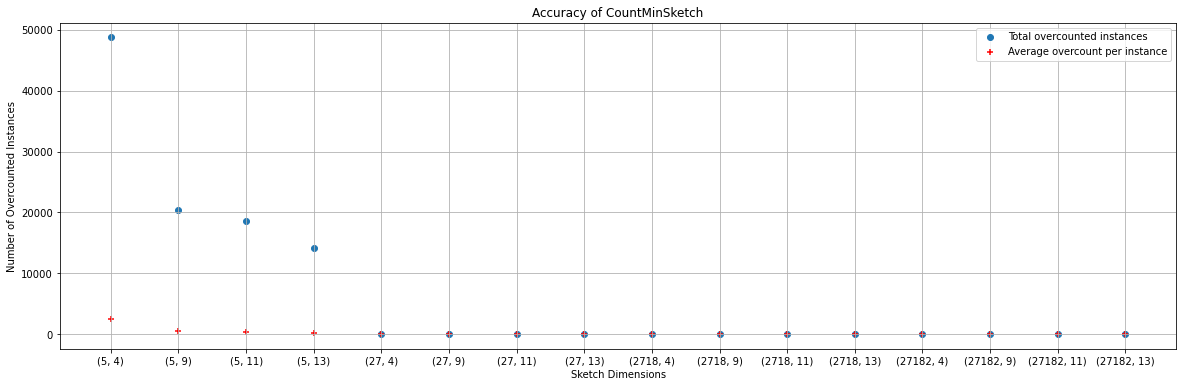

In [30]:
###
# What happens when you play with the w, d values (the dimensions of the sketch)
###


fig = plt.figure(figsize=(20,6))


plt.scatter(dims, accuracies, marker='o', alpha=1)

plt.scatter(dims, avg_disc, marker='+', color='r', alpha=1)
plt.grid()
plt.xlabel('Sketch Dimensions')
plt.ylabel('Number of Overcounted Instances')
plt.title('Accuracy of CountMinSketch')
plt.legend(['Total overcounted instances', 'Average overcount per instance'])

We can see above that there's a steep dropoff after the number of columns `w` starts to grow. Eventually, the sketch makes no mistakes and never overcounts.

In [31]:
###
# What are the 10 most frequent 3-grams and their frequencies when approximated?
###

print('The true counts of the 10 most frequent 3-grams:')
print(df_10_x.gram.value_counts()[:10])
print('---')
CMS_big = CountMinSketch(w=int(np.exp(1)/0.1), d=int(np.log(1/0.001)))
sketch_big = CMS_big.create_sketch(df_10_x.gram)

estimates = []
for item in df_10_x.gram.value_counts().index[:10].values:
    estimates.append((item, CMS_big.query_sketch(item)))

print('Estimate counts of the 10 most frequent 3-grams:')
print(estimates)

The true counts of the 10 most frequent 3-grams:
111    79369
131     4212
311     4184
113     4172
121     3836
112     3831
211     3819
333      287
313      265
133      256
Name: gram, dtype: int64
---
Estimate counts of the 10 most frequent 3-grams:
[(111, 79369), (131, 4212), (311, 4184), (113, 4172), (121, 3836), (112, 3831), (211, 3819), (333, 287), (313, 265), (133, 256)]


We can see from the results above that once we reach the dimensions of `w = e/0.1 = 27` and `d = log(1/0.001) = 6` we had 0 overcounts, meaning the true frequencies were identical to the approximated frequencies.

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Individual)

### 4a. Implementation

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual) (Andrew)

- Generate a vector of the occurences of a specific 3-gram. (value_counts())
- Generate a random vector with random values (normal distribution?) and that's a hyperplane because it's perpendicular to some kind of line. Store those hyperplanes, don't do it repeatedly (5, 10, 20, k?)
- Dot product for each random vector and the 3-gram profile (counts) vector:
    - provides a negative (encode as 0?) or positive value (encode as 1?)
    - Do this _ times, and concatenate each 0/1 value into a string of binary values (this is your "hash")
        - too few or too many hyperplanes is bad, choose a "sensible" value. Explain why. 
- Compute pairwise distances for all, and those that are malicious hosts.
    
    
- You have to transform your N-gram counts to 'feature vectors' such as a long list of counts. If you have e.g. 500 possible N-grams then you will have 500 counts. This you can see as a point in a 500-dimensional space
- To then choose random hyperplanes for separating you can generate K vectors of length 500. These could be your normal vectors (then your hyperplanes go through the origin).
- The counts of N-grams are a point in the space and they are on a certain side of the hyperplanes. You can determine this side by taking the sign of the dot product between your counts vector and the normal vector. Sign -1 could map to 0 and 1 to 1.

- **LSH w/ random hyperplanes:** Sicco - "You have some data points, then you have some planes that you draw, then for every plane you get a 0/1 classification whether or not a data point lies on which side of the hyperplane. Compute the labels for all datapoints, and then compute pairwise distances between data points that have that specific label. It can be compared against a full nearest-neighbor search to see performance/speed, but not required."

### 5a. Implementation - locality sensitive hashing

In [32]:
df_10_x['SrcAddr'] = df_10_enc.SrcAddr
df_10_x['DstAddr'] = df_10_enc.DstAddr

In [33]:
flow_names = []
for i in sorted(df_10_x.SrcAddr.unique()):
    for j in sorted(df_10_x.DstAddr.unique()):
        name = 'df_10_flow_' + str(i) + '_' + str(j)
        flow_names.append(name)

In [34]:
df_10_x

DTP    MetaLabel  EncLabel  gram  SrcAddr  DstAddr
0         3   Botnet-UDP         2   333        0        2
1         3   Botnet-UDP         2   333        0        2
2         3   Botnet-TCP         3   333        0       27
3         3   Botnet-UDP         2   333        0        2
4         3   Botnet-UDP         2   333        0       14
...     ...          ...       ...   ...      ...      ...
106347    1  Botnet-ICMP         1   111        0        3
106348    3   Botnet-UDP         2   113        7        2
106349    3   Botnet-TCP         3   133        7       10
106350    3   Botnet-UDP         2   333        0        2
106351    3   Botnet-TCP         3   333        0        1

[106352 rows x 6 columns]

In [43]:
# save the non-empty flow for later
flow = pd.DataFrame(df_10_x[(df_10_x.SrcAddr == 0) & (df_10_x.DstAddr == 3)])
non_empty_flows.append(flow)

# the profile for this specific src-dst flow
profile = pd.Series(flow.gram.value_counts()).reset_index(drop=False, inplace=False)
profile.columns = ['gram', 'counts']


# the number of random hyperplanes (arbitrary for now)
k = len(profile.gram.value_counts())

# the width of each bin (dunno what a good width is)
w = 5

# generate the random vectors
for m in range(k):

    # create a column of random gaussians
    rv_name = 'rv_' + str(m)
    profile[rv_name] = pd.Series(np.dot(np.random.normal(),x) for x in profile.counts)
    print(pd.Series(np.dot(np.random.normal(),x) for x in profile.counts))
    print(profile[rv_name])

#                 # the projection is the dot product of the n-grams * each random vector, plus some random variable b (between 0 and w), div by w
#                 proj = 'proj_' + str(i)
#                 b = np.random.random() * w
#                 df_10_x[proj] = pd.Series([np.floor((df_10_x.gram * df_10_x[col_name] + b) / w) for x in df_10_x.index])

0     2252.836231
1     -338.180284
2      771.553622
3     -247.742353
4     -377.063170
5     -205.007736
6     -661.601557
7      -27.519188
8       14.958589
9        5.439926
10      -9.489282
11       0.397799
12      13.857706
13     -25.782104
14      -5.381740
15     -11.424517
16       0.333404
17      13.847213
18      11.787363
19       7.065164
20      -1.971373
21       2.672123
22      -3.810350
23       1.540246
24       0.981220
25      -1.812396
26       1.218117
dtype: float64
0    -8338.609326
1     -107.110241
2      372.225142
3     -510.499964
4     -694.361785
5     -105.480709
6      269.945696
7       26.201463
8        8.759906
9      -20.045256
10     -19.745646
11      16.635374
12     -15.052536
13      32.537798
14      -0.156849
15     -15.231152
16      -5.890592
17      15.577898
18      -0.400894
19     -17.987189
20       2.039846
21      -3.105117
22       0.653610
23      -1.552521
24      -1.374262
25       0.685533
26       1.020243
Name: rv_0, d

In [117]:
src = sorted(df_10_x.SrcAddr.unique())
dst = sorted(df_10_x.DstAddr.unique())

non_empty_flows = []
profiles = []

for i in src:
    for j in dst:
        if not (df_10_x[(df_10_x.SrcAddr == i) & (df_10_x.DstAddr == j)].empty):
            
            
            
            
            
            # save the non-empty flow for later
            flow = pd.DataFrame(df_10_x[(df_10_x.SrcAddr == i) & (df_10_x.DstAddr == j)])
            non_empty_flows.append(flow)
            
            # the profile for this specific src-dst flow
            profile = pd.Series(flow.gram.value_counts()).reset_index(drop=False, inplace=False)
            profile.columns = ['gram', 'counts']
            
#             print('--------------')
#             print(profile)
#             print('Number of random hyperplanes (k = length of profile vector):', len(profile))
            
            
            
            # the number of random hyperplanes (arbitrary for now)
            k = len(profile)

            # the width of each bin (dunno what a good width is)
            w = 2

            
            
            
            
            
            # generate the random vectors
            for m in range(k):
                
                # create a column of random gaussians
                random_vector = 'rv_' + str(m)
                profile[random_vector] = pd.Series(np.random.normal()*x for x in profile.counts)
                

#                 print('---')
#                 print('Create a column of random gaussians of length k')
#                 print('Random vector name rv_name: ', rv_name)
#                 print('Random vector: ', profile[rv_name])
                
                
                
                
                
                
                ### the projection is the dot product of the n-grams * each random vector, 
                ### plus some random variable b (between 0 and w), div by w
                proj = 'proj_' + str(m)
                b = np.random.random() * w
                proj_vals = []

#                 print('---')
#                 print('Projection name: ', proj)
#                 print('b = ', b)


                
                for x in profile.index:
                    
                    
                    
                    # Encode the projections as 0 if negative, or 1 if positive
                    if (np.floor((np.dot(profile.counts.iloc[x], profile[rv_name].iloc[x]) + b) / w) <= 0):
                        proj_val = 0
                    else:
                        proj_val = 1
                        
                    proj_vals.append(proj_val)
                    
                    print('x: ', x)
                    print('profile.iloc[x]:', profile.iloc[x])
                    print('proj_val.iloc[x]:', proj_val)
    
    
    
    
    
                profile[proj] = proj_vals
                profiles.append(profile)
            

x:  0
profile.iloc[x]: gram      333.000000
counts      1.000000
rv_0        1.376749
Name: 0, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram      333.000000
counts     14.000000
rv_0        3.198016
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      323.00000
counts      1.00000
rv_0       -0.50554
Name: 1, dtype: float64
proj_val.iloc[x]: 0
x:  2
profile.iloc[x]: gram      133.000000
counts      1.000000
rv_0        0.217442
Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  3
profile.iloc[x]: gram      233.000000
counts      1.000000
rv_0       -0.490083
Name: 3, dtype: float64
proj_val.iloc[x]: 0
x:  4
profile.iloc[x]: gram      113.000000
counts      1.000000
rv_0        0.058569
Name: 4, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram      333.000000
counts     14.000000
rv_0        3.198016
proj_0      1.000000
rv_1      -28.826049
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      323.000000
counts 

x:  18
profile.iloc[x]: gram      333.000000
counts     13.000000
rv_0      -14.059098
proj_0      0.000000
rv_1       -4.881290
proj_1      0.000000
rv_2        1.882681
proj_2      0.000000
rv_3       -5.492218
proj_3      0.000000
rv_4       17.578064
proj_4      0.000000
rv_5        1.512945
proj_5      0.000000
rv_6        8.538537
Name: 18, dtype: float64
proj_val.iloc[x]: 0
x:  19
profile.iloc[x]: gram      312.000000
counts     13.000000
rv_0       -1.508468
proj_0      0.000000
rv_1      -10.807906
proj_1      0.000000
rv_2       -6.729405
proj_2      0.000000
rv_3       -7.719842
proj_3      0.000000
rv_4       -6.723231
proj_4      0.000000
rv_5      -10.425130
proj_5      0.000000
rv_6      -21.665325
Name: 19, dtype: float64
proj_val.iloc[x]: 0
x:  20
profile.iloc[x]: gram      232.000000
counts      2.000000
rv_0        3.732026
proj_0      1.000000
rv_1        0.686363
proj_1      1.000000
rv_2       -1.592723
proj_2      1.000000
rv_3       -1.005649
proj_3      1.00000

Name: 7, dtype: float64
proj_val.iloc[x]: 0
x:  8
profile.iloc[x]: gram       313.000000
counts      25.000000
rv_0       -34.816098
proj_0       0.000000
rv_1        13.598656
proj_1       0.000000
rv_2       -42.330199
proj_2       0.000000
rv_3        16.044367
proj_3       0.000000
rv_4       -24.570293
proj_4       0.000000
rv_5        -4.583646
proj_5       0.000000
rv_6        24.526027
proj_6       0.000000
rv_7        -5.156194
proj_7       0.000000
rv_8       -13.460829
proj_8       0.000000
rv_9        18.982980
proj_9       0.000000
rv_10       -8.274869
proj_10      0.000000
rv_11       52.753782
proj_11      0.000000
rv_12      -33.416765
Name: 8, dtype: float64
proj_val.iloc[x]: 0
x:  9
profile.iloc[x]: gram       122.000000
counts      23.000000
rv_0       -17.424713
proj_0       0.000000
rv_1        29.560409
proj_1       0.000000
rv_2        17.759655
proj_2       0.000000
rv_3        21.238347
proj_3       0.000000
rv_4        -9.839605
proj_4       0.000000
rv_5    

Name: 24, dtype: float64
proj_val.iloc[x]: 0
x:  25
profile.iloc[x]: gram       322.000000
counts       1.000000
rv_0         0.535215
proj_0       0.000000
rv_1        -1.625443
proj_1       1.000000
rv_2         0.607002
proj_2       0.000000
rv_3         0.670873
proj_3       0.000000
rv_4         0.191211
proj_4       0.000000
rv_5        -0.940734
proj_5       1.000000
rv_6        -1.952653
proj_6       0.000000
rv_7        -0.283180
proj_7       0.000000
rv_8        -0.355580
proj_8       1.000000
rv_9        -1.543768
proj_9       0.000000
rv_10        0.949855
proj_10      1.000000
rv_11        1.544920
proj_11      0.000000
rv_12        0.272302
proj_12      0.000000
rv_13       -1.265432
proj_13      0.000000
rv_14       -1.047975
proj_14      0.000000
rv_15       -1.763200
proj_15      0.000000
rv_16       -1.231503
Name: 25, dtype: float64
proj_val.iloc[x]: 0
x:  26
profile.iloc[x]: gram       323.000000
counts       1.000000
rv_0        -0.857402
proj_0       0.000000
rv_1

Name: 11, dtype: float64
proj_val.iloc[x]: 0
x:  12
profile.iloc[x]: gram       221.000000
counts      21.000000
rv_0       -25.896696
proj_0       0.000000
rv_1        33.874973
proj_1       0.000000
rv_2        18.880385
proj_2       0.000000
rv_3        -9.433254
proj_3       0.000000
rv_4       -10.228547
proj_4       0.000000
rv_5        40.536123
proj_5       0.000000
rv_6        -3.546433
proj_6       0.000000
rv_7        15.288966
proj_7       0.000000
rv_8        -9.696093
proj_8       0.000000
rv_9        -0.245115
proj_9       0.000000
rv_10      -30.041609
proj_10      0.000000
rv_11       32.864982
proj_11      0.000000
rv_12       17.981397
proj_12      0.000000
rv_13       12.073667
proj_13      0.000000
rv_14       46.924740
proj_14      0.000000
rv_15       -4.473768
proj_15      0.000000
rv_16       -9.380638
proj_16      0.000000
rv_17      -21.093009
proj_17      0.000000
rv_18       13.573154
proj_18      0.000000
rv_19       16.298008
proj_19      0.000000
rv_20  

Name: 17, dtype: float64
proj_val.iloc[x]: 0
x:  18
profile.iloc[x]: gram       333.000000
counts      13.000000
rv_0       -14.059098
proj_0       0.000000
rv_1        -4.881290
proj_1       0.000000
rv_2         1.882681
proj_2       0.000000
rv_3        -5.492218
proj_3       0.000000
rv_4        17.578064
proj_4       0.000000
rv_5         1.512945
proj_5       0.000000
rv_6         8.538537
proj_6       0.000000
rv_7        13.272210
proj_7       0.000000
rv_8        23.707741
proj_8       0.000000
rv_9         1.753913
proj_9       0.000000
rv_10       -0.214333
proj_10      0.000000
rv_11        1.281382
proj_11      0.000000
rv_12      -20.050271
proj_12      0.000000
rv_13      -14.062199
proj_13      0.000000
rv_14        0.997497
proj_14      0.000000
rv_15       -6.389097
proj_15      0.000000
rv_16        2.684536
proj_16      0.000000
rv_17      -18.085486
proj_17      0.000000
rv_18       30.687029
proj_18      0.000000
rv_19       25.600890
proj_19      0.000000
rv_20  

profile.iloc[x]: gram      321.000000
counts     17.000000
rv_0        0.276346
proj_0      1.000000
rv_1      -12.005727
proj_1      1.000000
rv_2       12.375138
proj_2      1.000000
rv_3       15.098744
Name: 16, dtype: float64
proj_val.iloc[x]: 1
x:  17
profile.iloc[x]: gram      333.000000
counts     13.000000
rv_0        3.044328
proj_0      1.000000
rv_1        0.677163
proj_1      1.000000
rv_2       -5.482585
proj_2      1.000000
rv_3        1.309979
Name: 17, dtype: float64
proj_val.iloc[x]: 1
x:  18
profile.iloc[x]: gram      132.000000
counts     11.000000
rv_0      -10.007311
proj_0      0.000000
rv_1      -12.142695
proj_1      0.000000
rv_2      -12.870866
proj_2      0.000000
rv_3       -0.758137
Name: 18, dtype: float64
proj_val.iloc[x]: 0
x:  19
profile.iloc[x]: gram      231.000000
counts     11.000000
rv_0       -7.657456
proj_0      0.000000
rv_1      -20.003621
proj_1      0.000000
rv_2       -8.645440
proj_2      0.000000
rv_3        9.960981
Name: 19, dtype: flo

Name: 16, dtype: float64
proj_val.iloc[x]: 1
x:  17
profile.iloc[x]: gram      333.000000
counts     13.000000
rv_0        3.044328
proj_0      1.000000
rv_1        0.677163
proj_1      1.000000
rv_2       -5.482585
proj_2      1.000000
rv_3        1.309979
proj_3      1.000000
rv_4      -13.448921
proj_4      1.000000
rv_5        1.914987
proj_5      1.000000
rv_6      -14.837413
proj_6      1.000000
rv_7      -27.542978
proj_7      1.000000
rv_8       19.145951
proj_8      1.000000
rv_9       19.137844
Name: 17, dtype: float64
proj_val.iloc[x]: 1
x:  18
profile.iloc[x]: gram      132.000000
counts     11.000000
rv_0      -10.007311
proj_0      0.000000
rv_1      -12.142695
proj_1      0.000000
rv_2      -12.870866
proj_2      0.000000
rv_3       -0.758137
proj_3      0.000000
rv_4       -1.084129
proj_4      0.000000
rv_5      -11.149985
proj_5      0.000000
rv_6       10.945533
proj_6      0.000000
rv_7       11.974776
proj_7      0.000000
rv_8        0.767685
proj_8      0.000000
r

Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  3
profile.iloc[x]: gram       211.000000
counts     404.000000
rv_0       -20.919023
proj_0       0.000000
rv_1       393.736476
proj_1       0.000000
rv_2       314.660944
proj_2       0.000000
rv_3       -57.342891
proj_3       0.000000
rv_4      -111.892645
proj_4       0.000000
rv_5      -479.972114
proj_5       0.000000
rv_6        69.503488
proj_6       0.000000
rv_7      -256.039381
proj_7       0.000000
rv_8         2.490596
proj_8       0.000000
rv_9       309.602684
proj_9       0.000000
rv_10     -837.348915
proj_10      0.000000
rv_11       19.768615
proj_11      0.000000
rv_12     -308.738120
proj_12      0.000000
rv_13      -25.592873
proj_13      0.000000
rv_14     -340.571754
proj_14      0.000000
rv_15      243.467757
proj_15      0.000000
rv_16     -323.932070
Name: 3, dtype: float64
proj_val.iloc[x]: 0
x:  4
profile.iloc[x]: gram       121.000000
counts     385.000000
rv_0       469.804955
proj_0       1.000000
rv_1    

profile.iloc[x]: gram        113.000000
counts      408.000000
rv_0       -377.107560
proj_0        0.000000
rv_1         33.001287
proj_1        0.000000
rv_2       -789.687355
proj_2        0.000000
rv_3         98.247591
proj_3        0.000000
rv_4       -223.640149
proj_4        0.000000
rv_5       -322.012540
proj_5        0.000000
rv_6        271.368296
proj_6        0.000000
rv_7       1156.260196
proj_7        0.000000
rv_8       -272.515506
proj_8        0.000000
rv_9        875.730332
proj_9        0.000000
rv_10      -276.535810
proj_10       0.000000
rv_11      -380.858478
proj_11       0.000000
rv_12      -288.193908
proj_12       0.000000
rv_13      -342.286413
proj_13       0.000000
rv_14      1103.243479
proj_14       0.000000
rv_15       379.400264
proj_15       0.000000
rv_16       714.309042
proj_16       0.000000
rv_17       953.203177
proj_17       0.000000
rv_18        95.041336
proj_18       0.000000
rv_19      1081.649569
proj_19       0.000000
rv_20      -845.2

x:  2
profile.iloc[x]: gram      113.000000
counts    415.000000
rv_0      752.951053
Name: 2, dtype: float64
proj_val.iloc[x]: 1
x:  3
profile.iloc[x]: gram      131.000000
counts    399.000000
rv_0     -677.349243
Name: 3, dtype: float64
proj_val.iloc[x]: 0
x:  4
profile.iloc[x]: gram      112.000000
counts    393.000000
rv_0      448.994063
Name: 4, dtype: float64
proj_val.iloc[x]: 1
x:  5
profile.iloc[x]: gram      211.000000
counts    390.000000
rv_0       25.292992
Name: 5, dtype: float64
proj_val.iloc[x]: 1
x:  6
profile.iloc[x]: gram      121.000000
counts    360.000000
rv_0       91.192746
Name: 6, dtype: float64
proj_val.iloc[x]: 1
x:  7
profile.iloc[x]: gram      221.000000
counts     33.000000
rv_0       45.963834
Name: 7, dtype: float64
proj_val.iloc[x]: 1
x:  8
profile.iloc[x]: gram      313.000000
counts     29.000000
rv_0      -16.644356
Name: 8, dtype: float64
proj_val.iloc[x]: 0
x:  9
profile.iloc[x]: gram      133.000000
counts     28.000000
rv_0       21.460313
Name

proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      311.000000
counts    425.000000
rv_0      689.901297
proj_0      1.000000
rv_1       54.230751
proj_1      1.000000
rv_2      841.169774
proj_2      1.000000
rv_3     -344.339857
proj_3      1.000000
rv_4      -26.832301
proj_4      1.000000
rv_5      189.496863
proj_5      1.000000
rv_6     -135.722723
proj_6      1.000000
rv_7     -475.255903
proj_7      1.000000
rv_8     -103.840321
proj_8      1.000000
rv_9      -71.693982
Name: 1, dtype: float64
proj_val.iloc[x]: 1
x:  2
profile.iloc[x]: gram       113.000000
counts     415.000000
rv_0       752.951053
proj_0       1.000000
rv_1      -231.720249
proj_1       1.000000
rv_2      -619.262409
proj_2       1.000000
rv_3      1165.113757
proj_3       1.000000
rv_4      -746.823922
proj_4       1.000000
rv_5      -726.403469
proj_5       1.000000
rv_6         6.479510
proj_6       1.000000
rv_7       549.155025
proj_7       1.000000
rv_8        24.295788
proj_8       1.000000
rv_9     

Name: 15, dtype: float64
proj_val.iloc[x]: 0
x:  16
profile.iloc[x]: gram       122.000000
counts      18.000000
rv_0       -15.200192
proj_0       0.000000
rv_1        -2.388032
proj_1       0.000000
rv_2        29.451932
proj_2       0.000000
rv_3       -26.390567
proj_3       0.000000
rv_4        29.246234
proj_4       0.000000
rv_5       -18.578059
proj_5       0.000000
rv_6         3.735292
proj_6       0.000000
rv_7        23.605346
proj_7       0.000000
rv_8        26.132726
proj_8       0.000000
rv_9        13.569264
proj_9       0.000000
rv_10       19.505197
proj_10      0.000000
rv_11       23.127838
proj_11      0.000000
rv_12       32.188018
proj_12      0.000000
rv_13      -19.179838
proj_13      0.000000
rv_14      -10.300532
proj_14      0.000000
rv_15       43.690646
Name: 16, dtype: float64
proj_val.iloc[x]: 0
x:  17
profile.iloc[x]: gram       312.000000
counts      13.000000
rv_0        -8.364907
proj_0       0.000000
rv_1        -6.489796
proj_1       0.000000
rv_2

Name: 19, dtype: float64
proj_val.iloc[x]: 1
x:  20
profile.iloc[x]: gram       233.000000
counts       1.000000
rv_0         0.827548
proj_0       1.000000
rv_1         0.141628
proj_1       1.000000
rv_2        -0.066305
proj_2       1.000000
rv_3         0.765886
proj_3       1.000000
rv_4        -0.550803
proj_4       1.000000
rv_5         1.072212
proj_5       0.000000
rv_6         0.535152
proj_6       0.000000
rv_7         0.566539
proj_7       0.000000
rv_8         0.210278
proj_8       1.000000
rv_9        -1.189572
proj_9       1.000000
rv_10       -1.293611
proj_10      1.000000
rv_11       -1.795017
proj_11      1.000000
rv_12       -1.079863
proj_12      1.000000
rv_13       -0.690614
proj_13      1.000000
rv_14        2.052436
proj_14      0.000000
rv_15        0.110704
proj_15      0.000000
rv_16        0.529179
proj_16      1.000000
rv_17        0.223563
proj_17      0.000000
rv_18       -1.763392
proj_18      0.000000
rv_19       -1.587787
Name: 20, dtype: float64
proj

x:  0
profile.iloc[x]: gram      333.000000
counts      9.000000
rv_0        4.915695
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      323.000000
counts      3.000000
rv_0        3.529986
Name: 1, dtype: float64
proj_val.iloc[x]: 1
x:  2
profile.iloc[x]: gram      233.000000
counts      3.000000
rv_0        0.260272
Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram      333.000000
counts      9.000000
rv_0        4.915695
proj_0      1.000000
rv_1       12.382405
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      323.000000
counts      3.000000
rv_0        3.529986
proj_0      1.000000
rv_1        2.306295
Name: 1, dtype: float64
proj_val.iloc[x]: 1
x:  2
profile.iloc[x]: gram      233.000000
counts      3.000000
rv_0        0.260272
proj_0      0.000000
rv_1       -3.878238
Name: 2, dtype: float64
proj_val.iloc[x]: 1
x:  0
profile.iloc[x]: gram      333.000000
counts      9.000000
rv_0        4.915695
proj_0  

Name: 4, dtype: float64
proj_val.iloc[x]: 0
x:  5
profile.iloc[x]: gram      121.000000
counts    353.000000
rv_0     -332.028098
proj_0      0.000000
rv_1     -822.002184
proj_1      0.000000
rv_2     -590.394900
proj_2      0.000000
rv_3      253.653594
proj_3      0.000000
rv_4     -507.107823
proj_4      0.000000
rv_5      192.365008
proj_5      0.000000
rv_6     -213.232390
proj_6      0.000000
rv_7      288.386802
proj_7      0.000000
rv_8       52.300319
Name: 5, dtype: float64
proj_val.iloc[x]: 0
x:  6
profile.iloc[x]: gram      311.000000
counts    334.000000
rv_0     -137.904282
proj_0      0.000000
rv_1      233.145371
proj_1      0.000000
rv_2     -667.852599
proj_2      0.000000
rv_3      576.508843
proj_3      0.000000
rv_4      265.954380
proj_4      0.000000
rv_5       72.269531
proj_5      0.000000
rv_6      203.740908
proj_6      0.000000
rv_7      188.188525
proj_7      0.000000
rv_8      -18.503314
Name: 6, dtype: float64
proj_val.iloc[x]: 0
x:  7
profile.iloc[x]: g

Name: 25, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram         111.000000
counts      7489.000000
rv_0       15194.060556
proj_0         1.000000
rv_1        -572.040701
proj_1         1.000000
rv_2       -8730.130030
proj_2         1.000000
rv_3      -11298.233330
proj_3         1.000000
rv_4        8378.933763
proj_4         1.000000
rv_5       11422.727986
proj_5         1.000000
rv_6         843.435038
proj_6         1.000000
rv_7        7565.814505
proj_7         1.000000
rv_8        3160.240231
proj_8         1.000000
rv_9       -3217.141102
proj_9         1.000000
rv_10       4520.294149
proj_10        1.000000
rv_11       3356.487228
proj_11        1.000000
rv_12        -22.148158
proj_12        1.000000
rv_13      16490.539686
proj_13        1.000000
rv_14      -7344.634940
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram       113.000000
counts     415.000000
rv_0       195.523766
proj_0       1.000000
rv_1       641.976766
proj_1     

Name: 17, dtype: float64
proj_val.iloc[x]: 1
x:  18
profile.iloc[x]: gram       333.000000
counts      11.000000
rv_0        -0.529497
proj_0       0.000000
rv_1        19.281080
proj_1       0.000000
rv_2       -11.863646
proj_2       0.000000
rv_3        12.778177
proj_3       0.000000
rv_4         1.620189
proj_4       0.000000
rv_5        -5.108845
proj_5       0.000000
rv_6        19.728198
proj_6       0.000000
rv_7        -2.649158
proj_7       0.000000
rv_8        -9.037689
proj_8       0.000000
rv_9        -4.300460
proj_9       0.000000
rv_10        4.798613
proj_10      0.000000
rv_11       -8.791911
proj_11      0.000000
rv_12        0.076752
proj_12      0.000000
rv_13       -5.003294
proj_13      0.000000
rv_14        6.056382
proj_14      0.000000
rv_15       -7.563117
proj_15      0.000000
rv_16       -5.136439
proj_16      0.000000
rv_17       -1.233928
proj_17      0.000000
rv_18        5.353922
Name: 18, dtype: float64
proj_val.iloc[x]: 0
x:  19
profile.iloc[x]: gram

Name: 19, dtype: float64
proj_val.iloc[x]: 0
x:  20
profile.iloc[x]: gram       323.000000
counts       3.000000
rv_0         3.817967
proj_0       1.000000
rv_1         2.507785
proj_1       1.000000
rv_2        -3.065810
proj_2       1.000000
rv_3        -3.726481
proj_3       1.000000
rv_4         1.763179
proj_4       1.000000
rv_5         2.509257
proj_5       1.000000
rv_6        -3.310978
proj_6       1.000000
rv_7        -1.066251
proj_7       1.000000
rv_8        -3.964704
proj_8       1.000000
rv_9         1.581134
proj_9       1.000000
rv_10        0.569836
proj_10      1.000000
rv_11        0.046018
proj_11      1.000000
rv_12       -4.355018
proj_12      1.000000
rv_13        3.668489
proj_13      1.000000
rv_14        2.129467
proj_14      1.000000
rv_15       -2.320973
proj_15      1.000000
rv_16        1.153140
proj_16      1.000000
rv_17        7.053272
proj_17      1.000000
rv_18       -0.986621
proj_18      1.000000
rv_19       -3.378726
proj_19      1.000000
rv_20  

x:  0
profile.iloc[x]: gram      333.000000
counts      8.000000
rv_0       11.345361
proj_0      1.000000
rv_1      -12.045586
proj_1      1.000000
rv_2        2.254153
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      323.000000
counts      2.000000
rv_0        2.423879
proj_0      1.000000
rv_1        0.547333
proj_1      1.000000
rv_2       -2.954489
Name: 1, dtype: float64
proj_val.iloc[x]: 1
x:  2
profile.iloc[x]: gram      233.000000
counts      2.000000
rv_0        3.560353
proj_0      1.000000
rv_1       -0.878131
proj_1      1.000000
rv_2       -4.767068
Name: 2, dtype: float64
proj_val.iloc[x]: 1
x:  3
profile.iloc[x]: gram      113.000000
counts      1.000000
rv_0       -1.531618
proj_0      0.000000
rv_1       -0.500291
proj_1      0.000000
rv_2        0.072141
Name: 3, dtype: float64
proj_val.iloc[x]: 0
x:  4
profile.iloc[x]: gram      133.000000
counts      1.000000
rv_0       -0.300360
proj_0      0.000000
rv_1        0.399113
proj_1      0.00

Name: 7, dtype: float64
proj_val.iloc[x]: 0
x:  8
profile.iloc[x]: gram      212.000000
counts     30.000000
rv_0       16.158472
proj_0      1.000000
rv_1       26.615025
proj_1      1.000000
rv_2       39.871263
proj_2      1.000000
rv_3       20.649794
proj_3      1.000000
rv_4      -19.507039
proj_4      1.000000
rv_5       13.640456
proj_5      1.000000
rv_6      -32.367175
proj_6      1.000000
rv_7       28.759334
Name: 8, dtype: float64
proj_val.iloc[x]: 1
x:  9
profile.iloc[x]: gram      313.000000
counts     30.000000
rv_0       30.517719
proj_0      1.000000
rv_1       -0.551637
proj_1      1.000000
rv_2      -26.394643
proj_2      1.000000
rv_3      -12.998811
proj_3      1.000000
rv_4       53.037250
proj_4      1.000000
rv_5      -33.579217
proj_5      1.000000
rv_6       34.190997
proj_6      1.000000
rv_7       -3.491753
Name: 9, dtype: float64
proj_val.iloc[x]: 1
x:  10
profile.iloc[x]: gram      312.000000
counts     25.000000
rv_0       -6.929140
proj_0      0.000000


x:  16
profile.iloc[x]: gram       213.000000
counts      17.000000
rv_0         4.743114
proj_0       1.000000
rv_1        17.690302
proj_1       1.000000
rv_2         5.539985
proj_2       1.000000
rv_3       -15.443960
proj_3       1.000000
rv_4        42.823415
proj_4       1.000000
rv_5        21.040792
proj_5       1.000000
rv_6         0.680760
proj_6       1.000000
rv_7        -2.195053
proj_7       1.000000
rv_8        15.252086
proj_8       1.000000
rv_9        24.412187
proj_9       1.000000
rv_10       -2.693730
proj_10      1.000000
rv_11       31.758919
proj_11      1.000000
rv_12       31.939219
proj_12      1.000000
rv_13      -25.124180
Name: 16, dtype: float64
proj_val.iloc[x]: 1
x:  17
profile.iloc[x]: gram       123.000000
counts      14.000000
rv_0       -15.646358
proj_0       0.000000
rv_1       -11.732672
proj_1       0.000000
rv_2       -11.024281
proj_2       0.000000
rv_3         1.244097
proj_3       0.000000
rv_4       -16.090940
proj_4       0.000000
rv_5 

Name: 21, dtype: float64
proj_val.iloc[x]: 0
x:  22
profile.iloc[x]: gram       233.000000
counts       1.000000
rv_0         0.159352
proj_0       0.000000
rv_1        -0.771190
proj_1       0.000000
rv_2        -0.502451
proj_2       0.000000
rv_3         1.860463
proj_3       0.000000
rv_4         1.185620
proj_4       0.000000
rv_5         0.630415
proj_5       0.000000
rv_6        -0.518922
proj_6       0.000000
rv_7        -1.267726
proj_7       0.000000
rv_8         0.847872
proj_8       0.000000
rv_9         0.242395
proj_9       0.000000
rv_10        1.399749
proj_10      0.000000
rv_11       -0.318623
proj_11      0.000000
rv_12        0.585295
proj_12      0.000000
rv_13       -0.782253
proj_13      0.000000
rv_14       -0.345676
proj_14      0.000000
rv_15       -0.258444
proj_15      0.000000
rv_16        0.718391
proj_16      0.000000
rv_17       -0.249200
proj_17      0.000000
rv_18        1.072911
Name: 22, dtype: float64
proj_val.iloc[x]: 0
x:  23
profile.iloc[x]: gram

Name: 23, dtype: float64
proj_val.iloc[x]: 0
x:  24
profile.iloc[x]: gram       332.000000
counts       1.000000
rv_0         0.209233
proj_0       0.000000
rv_1        -0.332699
proj_1       0.000000
rv_2        -0.790101
proj_2       0.000000
rv_3        -1.853581
proj_3       0.000000
rv_4        -0.450409
proj_4       0.000000
rv_5         1.319819
proj_5       0.000000
rv_6         0.223528
proj_6       0.000000
rv_7         0.365043
proj_7       0.000000
rv_8         0.393808
proj_8       0.000000
rv_9        -0.335406
proj_9       0.000000
rv_10       -0.938629
proj_10      0.000000
rv_11       -0.197215
proj_11      0.000000
rv_12        0.212082
proj_12      0.000000
rv_13       -0.694341
proj_13      0.000000
rv_14        0.038624
proj_14      0.000000
rv_15        1.415857
proj_15      0.000000
rv_16       -0.142930
proj_16      0.000000
rv_17       -0.098598
proj_17      0.000000
rv_18       -1.144886
proj_18      0.000000
rv_19        1.658177
proj_19      0.000000
rv_20  

x:  0
profile.iloc[x]: gram       111.000000
counts    8839.000000
rv_0      3839.971123
proj_0       1.000000
rv_1      9540.470042
proj_1       1.000000
rv_2       434.717797
Name: 0, dtype: float64
proj_val.iloc[x]: 1
x:  1
profile.iloc[x]: gram      131.000000
counts    523.000000
rv_0     -233.678873
proj_0      0.000000
rv_1     -537.599606
proj_1      0.000000
rv_2      -21.942881
Name: 1, dtype: float64
proj_val.iloc[x]: 0
x:  2
profile.iloc[x]: gram      311.000000
counts    474.000000
rv_0     -621.032632
proj_0      0.000000
rv_1      589.010036
proj_1      0.000000
rv_2      681.146519
Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  3
profile.iloc[x]: gram      121.000000
counts    458.000000
rv_0      392.016995
proj_0      1.000000
rv_1     -380.694722
proj_1      1.000000
rv_2       10.343724
Name: 3, dtype: float64
proj_val.iloc[x]: 1
x:  4
profile.iloc[x]: gram      112.000000
counts    454.000000
rv_0     -185.748502
proj_0      0.000000
rv_1     -152.301280
proj_1   

Name: 10, dtype: float64
proj_val.iloc[x]: 0
x:  11
profile.iloc[x]: gram      133.000000
counts     26.000000
rv_0       -2.140819
proj_0      0.000000
rv_1       26.158338
proj_1      0.000000
rv_2       -4.884807
proj_2      0.000000
rv_3      -14.684784
proj_3      0.000000
rv_4       -4.871201
proj_4      0.000000
rv_5       11.439496
proj_5      0.000000
rv_6      -19.276769
proj_6      0.000000
rv_7        4.630073
proj_7      0.000000
rv_8        3.120380
Name: 11, dtype: float64
proj_val.iloc[x]: 0
x:  12
profile.iloc[x]: gram      213.000000
counts     18.000000
rv_0      -34.795947
proj_0      0.000000
rv_1       12.900142
proj_1      0.000000
rv_2        0.387612
proj_2      0.000000
rv_3       23.114723
proj_3      0.000000
rv_4       17.659531
proj_4      0.000000
rv_5        1.653296
proj_5      0.000000
rv_6        4.456161
proj_6      0.000000
rv_7      -34.202744
proj_7      0.000000
rv_8       15.014943
Name: 12, dtype: float64
proj_val.iloc[x]: 0
x:  13
profile.iloc

Name: 14, dtype: float64
proj_val.iloc[x]: 0
x:  15
profile.iloc[x]: gram       212.000000
counts      16.000000
rv_0       -32.650106
proj_0       0.000000
rv_1        14.252542
proj_1       0.000000
rv_2       -22.045393
proj_2       0.000000
rv_3        -1.550284
proj_3       0.000000
rv_4         6.790825
proj_4       0.000000
rv_5       -12.289541
proj_5       0.000000
rv_6        15.184147
proj_6       0.000000
rv_7        14.254043
proj_7       0.000000
rv_8        -3.117505
proj_8       0.000000
rv_9         9.682613
proj_9       0.000000
rv_10        6.958383
proj_10      0.000000
rv_11        6.374849
proj_11      0.000000
rv_12      -21.624034
proj_12      0.000000
rv_13        9.340708
proj_13      0.000000
rv_14       -2.275186
Name: 15, dtype: float64
proj_val.iloc[x]: 0
x:  16
profile.iloc[x]: gram       123.000000
counts      14.000000
rv_0         7.120581
proj_0       1.000000
rv_1         7.485563
proj_1       1.000000
rv_2       -11.037052
proj_2       1.000000
rv_3

Name: 3, dtype: float64
proj_val.iloc[x]: 1
x:  4
profile.iloc[x]: gram       112.000000
counts     454.000000
rv_0      -185.748502
proj_0       0.000000
rv_1      -152.301280
proj_1       0.000000
rv_2       -38.304449
proj_2       0.000000
rv_3       126.888328
proj_3       0.000000
rv_4      -142.883446
proj_4       0.000000
rv_5        42.664474
proj_5       0.000000
rv_6      -488.853045
proj_6       0.000000
rv_7      -354.305728
proj_7       0.000000
rv_8        97.423222
proj_8       0.000000
rv_9       438.249216
proj_9       0.000000
rv_10      259.720533
proj_10      0.000000
rv_11     -302.173486
proj_11      0.000000
rv_12     -887.361844
proj_12      0.000000
rv_13     -163.309850
proj_13      0.000000
rv_14      495.391078
proj_14      0.000000
rv_15     -503.778729
proj_15      0.000000
rv_16     -715.690960
proj_16      0.000000
rv_17      171.330945
proj_17      0.000000
rv_18      259.517381
proj_18      0.000000
rv_19     -659.104510
Name: 4, dtype: float64
proj_va

Name: 5, dtype: float64
proj_val.iloc[x]: 1
x:  6
profile.iloc[x]: gram       211.000000
counts     411.000000
rv_0         2.001556
proj_0       1.000000
rv_1      -462.143566
proj_1       1.000000
rv_2       649.379716
proj_2       1.000000
rv_3       137.694248
proj_3       1.000000
rv_4       114.329161
proj_4       1.000000
rv_5       284.591126
proj_5       1.000000
rv_6      -320.313184
proj_6       1.000000
rv_7       -25.039764
proj_7       1.000000
rv_8       -41.769347
proj_8       1.000000
rv_9       392.619035
proj_9       1.000000
rv_10      465.859750
proj_10      1.000000
rv_11      -24.939517
proj_11      1.000000
rv_12       11.245630
proj_12      1.000000
rv_13     -278.266711
proj_13      1.000000
rv_14     -524.341755
proj_14      1.000000
rv_15      -72.295177
proj_15      1.000000
rv_16      810.878864
proj_16      1.000000
rv_17      -73.752800
proj_17      1.000000
rv_18       17.986492
proj_18      1.000000
rv_19     -462.198587
proj_19      1.000000
rv_20    

Name: 18, dtype: float64
proj_val.iloc[x]: 0
x:  19
profile.iloc[x]: gram      333.000000
counts     12.000000
rv_0       -3.754655
proj_0      0.000000
rv_1       -3.334797
proj_1      0.000000
rv_2       -2.517880
Name: 19, dtype: float64
proj_val.iloc[x]: 0
x:  20
profile.iloc[x]: gram      332.000000
counts      2.000000
rv_0       -2.474684
proj_0      0.000000
rv_1        1.987640
proj_1      0.000000
rv_2        1.126802
Name: 20, dtype: float64
proj_val.iloc[x]: 0
x:  21
profile.iloc[x]: gram      222.000000
counts      2.000000
rv_0       -1.896614
proj_0      0.000000
rv_1        1.598388
proj_1      0.000000
rv_2       -0.639744
Name: 21, dtype: float64
proj_val.iloc[x]: 0
x:  22
profile.iloc[x]: gram      223.000000
counts      2.000000
rv_0       -1.713399
proj_0      0.000000
rv_1        2.078057
proj_1      0.000000
rv_2        2.387861
Name: 22, dtype: float64
proj_val.iloc[x]: 0
x:  23
profile.iloc[x]: gram      232.000000
counts      1.000000
rv_0        0.139707
proj

Name: 23, dtype: float64
proj_val.iloc[x]: 0
x:  24
profile.iloc[x]: gram      233.000000
counts      1.000000
rv_0       -0.898649
proj_0      0.000000
rv_1       -0.188251
proj_1      0.000000
rv_2       -0.331723
proj_2      0.000000
rv_3       -2.007894
proj_3      0.000000
rv_4        1.021966
proj_4      0.000000
rv_5       -1.824950
proj_5      0.000000
rv_6        0.050928
proj_6      0.000000
rv_7       -0.346792
proj_7      0.000000
rv_8        0.215884
proj_8      0.000000
rv_9       -0.016205
Name: 24, dtype: float64
proj_val.iloc[x]: 0
x:  25
profile.iloc[x]: gram      322.000000
counts      1.000000
rv_0       -0.243112
proj_0      0.000000
rv_1        1.137476
proj_1      0.000000
rv_2        0.202414
proj_2      0.000000
rv_3       -0.004812
proj_3      0.000000
rv_4        2.852379
proj_4      0.000000
rv_5        0.345960
proj_5      0.000000
rv_6        0.266873
proj_6      0.000000
rv_7        1.838022
proj_7      0.000000
rv_8        1.425141
proj_8      0.000000
r

Name: 13, dtype: float64
proj_val.iloc[x]: 0
x:  14
profile.iloc[x]: gram       123.000000
counts      19.000000
rv_0        18.222337
proj_0       1.000000
rv_1         8.618592
proj_1       1.000000
rv_2       -11.947687
proj_2       1.000000
rv_3         9.146180
proj_3       1.000000
rv_4         6.781435
proj_4       1.000000
rv_5        -4.649247
proj_5       1.000000
rv_6       -32.366209
proj_6       1.000000
rv_7        27.037668
proj_7       1.000000
rv_8         9.769464
proj_8       1.000000
rv_9       -10.700330
proj_9       1.000000
rv_10       -0.291023
proj_10      1.000000
rv_11      -20.468772
proj_11      1.000000
rv_12      -14.948599
proj_12      1.000000
rv_13      -24.700686
proj_13      1.000000
rv_14       31.539353
proj_14      1.000000
rv_15       -2.622028
Name: 14, dtype: float64
proj_val.iloc[x]: 1
x:  15
profile.iloc[x]: gram       213.000000
counts      19.000000
rv_0       -25.008779
proj_0       0.000000
rv_1       -25.780742
proj_1       0.000000
rv_2

Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  3
profile.iloc[x]: gram       112.000000
counts     427.000000
rv_0       321.881270
proj_0       1.000000
rv_1       356.828041
proj_1       1.000000
rv_2       407.357137
proj_2       1.000000
rv_3       -70.177839
proj_3       1.000000
rv_4       762.260884
proj_4       1.000000
rv_5       -87.416387
proj_5       1.000000
rv_6       289.237006
proj_6       1.000000
rv_7      -300.551242
proj_7       1.000000
rv_8      -394.917658
proj_8       1.000000
rv_9       401.592461
proj_9       1.000000
rv_10      104.305073
proj_10      1.000000
rv_11     -560.546742
proj_11      1.000000
rv_12      175.550927
proj_12      1.000000
rv_13      609.266379
proj_13      1.000000
rv_14     -585.565833
proj_14      1.000000
rv_15     -633.418977
proj_15      1.000000
rv_16     -213.037415
proj_16      1.000000
rv_17       84.392873
proj_17      1.000000
rv_18      327.275015
proj_18      1.000000
rv_19     -111.252938
proj_19      1.000000
rv_20    

Name: 14, dtype: float64
proj_val.iloc[x]: 1
x:  15
profile.iloc[x]: gram       213.000000
counts      19.000000
rv_0       -25.008779
proj_0       0.000000
rv_1       -25.780742
proj_1       0.000000
rv_2        -5.169212
proj_2       0.000000
rv_3        23.413878
proj_3       0.000000
rv_4       -18.371313
proj_4       0.000000
rv_5        -6.347141
proj_5       0.000000
rv_6         2.744206
proj_6       0.000000
rv_7         8.928404
proj_7       0.000000
rv_8       -16.505347
proj_8       0.000000
rv_9        -0.507586
proj_9       0.000000
rv_10      -26.584953
proj_10      0.000000
rv_11        9.108892
proj_11      0.000000
rv_12        1.921592
proj_12      0.000000
rv_13       -3.288138
proj_13      0.000000
rv_14       20.932069
proj_14      0.000000
rv_15       -1.139142
proj_15      0.000000
rv_16       11.679796
proj_16      0.000000
rv_17        0.459309
proj_17      0.000000
rv_18       29.397091
proj_18      0.000000
rv_19        2.691140
proj_19      0.000000
rv_20  

Name: 2, dtype: float64
proj_val.iloc[x]: 1
x:  3
profile.iloc[x]: gram      311.000000
counts    397.000000
rv_0      650.770851
proj_0      1.000000
rv_1     -159.937842
proj_1      1.000000
rv_2      437.475738
proj_2      1.000000
rv_3     -288.046967
proj_3      1.000000
rv_4     -341.395502
Name: 3, dtype: float64
proj_val.iloc[x]: 1
x:  4
profile.iloc[x]: gram      121.000000
counts    383.000000
rv_0      506.001233
proj_0      1.000000
rv_1       25.303009
proj_1      1.000000
rv_2     -163.778007
proj_2      1.000000
rv_3     -525.918812
proj_3      1.000000
rv_4       80.190255
Name: 4, dtype: float64
proj_val.iloc[x]: 1
x:  5
profile.iloc[x]: gram      112.000000
counts    372.000000
rv_0     -178.965562
proj_0      0.000000
rv_1       61.311268
proj_1      0.000000
rv_2      262.960177
proj_2      0.000000
rv_3      166.105443
proj_3      0.000000
rv_4     -321.669586
Name: 5, dtype: float64
proj_val.iloc[x]: 0
x:  6
profile.iloc[x]: gram      211.000000
counts    369.0000

Name: 2, dtype: float64
proj_val.iloc[x]: 1
x:  3
profile.iloc[x]: gram       311.000000
counts     397.000000
rv_0       650.770851
proj_0       1.000000
rv_1      -159.937842
proj_1       1.000000
rv_2       437.475738
proj_2       1.000000
rv_3      -288.046967
proj_3       1.000000
rv_4      -341.395502
proj_4       1.000000
rv_5      -226.980122
proj_5       1.000000
rv_6      -200.889973
proj_6       1.000000
rv_7       221.195366
proj_7       1.000000
rv_8      -533.185526
proj_8       1.000000
rv_9       491.519310
proj_9       1.000000
rv_10     -535.538027
proj_10      1.000000
rv_11     -100.745435
proj_11      1.000000
rv_12      407.245482
Name: 3, dtype: float64
proj_val.iloc[x]: 1
x:  4
profile.iloc[x]: gram       121.000000
counts     383.000000
rv_0       506.001233
proj_0       1.000000
rv_1        25.303009
proj_1       1.000000
rv_2      -163.778007
proj_2       1.000000
rv_3      -525.918812
proj_3       1.000000
rv_4        80.190255
proj_4       1.000000
rv_5    

Name: 4, dtype: float64
proj_val.iloc[x]: 1
x:  5
profile.iloc[x]: gram       112.000000
counts     372.000000
rv_0      -178.965562
proj_0       0.000000
rv_1        61.311268
proj_1       0.000000
rv_2       262.960177
proj_2       0.000000
rv_3       166.105443
proj_3       0.000000
rv_4      -321.669586
proj_4       0.000000
rv_5        73.553198
proj_5       0.000000
rv_6      -453.748308
proj_6       0.000000
rv_7        63.958759
proj_7       0.000000
rv_8      -374.785334
proj_8       0.000000
rv_9        77.438844
proj_9       0.000000
rv_10      -80.403526
proj_10      0.000000
rv_11      146.771501
proj_11      0.000000
rv_12      238.839843
proj_12      0.000000
rv_13      341.208321
proj_13      0.000000
rv_14     -220.748545
proj_14      0.000000
rv_15      294.337065
proj_15      0.000000
rv_16     -351.747582
proj_16      0.000000
rv_17     -171.542494
proj_17      0.000000
rv_18     -417.177147
proj_18      0.000000
rv_19     -111.649425
Name: 5, dtype: float64
proj_va

x:  0
profile.iloc[x]: gram      333.000000
counts      8.000000
rv_0       -3.763064
Name: 0, dtype: float64
proj_val.iloc[x]: 0
x:  1
profile.iloc[x]: gram      323.000000
counts      3.000000
rv_0        2.318602
Name: 1, dtype: float64
proj_val.iloc[x]: 1
x:  2
profile.iloc[x]: gram      233.000000
counts      3.000000
rv_0       -3.099059
Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram      333.000000
counts      8.000000
rv_0       -3.763064
proj_0      0.000000
rv_1       -3.136701
Name: 0, dtype: float64
proj_val.iloc[x]: 0
x:  1
profile.iloc[x]: gram      323.000000
counts      3.000000
rv_0        2.318602
proj_0      1.000000
rv_1       -1.236520
Name: 1, dtype: float64
proj_val.iloc[x]: 1
x:  2
profile.iloc[x]: gram      233.000000
counts      3.000000
rv_0       -3.099059
proj_0      0.000000
rv_1        4.559243
Name: 2, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram      333.000000
counts      8.000000
rv_0       -3.763064
proj_0  

profile.iloc[x]: gram      132.000000
counts     18.000000
rv_0       -8.982997
proj_0      0.000000
rv_1       -1.939580
proj_1      0.000000
rv_2       -6.432563
proj_2      0.000000
rv_3       34.611711
proj_3      0.000000
rv_4       14.862281
proj_4      0.000000
rv_5      -52.918395
proj_5      0.000000
rv_6       14.387528
proj_6      0.000000
rv_7       18.776849
Name: 12, dtype: float64
proj_val.iloc[x]: 0
x:  13
profile.iloc[x]: gram      122.000000
counts     18.000000
rv_0       -0.667673
proj_0      0.000000
rv_1        4.147367
proj_1      0.000000
rv_2       -7.644090
proj_2      0.000000
rv_3        3.560230
proj_3      0.000000
rv_4        3.721377
proj_4      0.000000
rv_5      -18.589661
proj_5      0.000000
rv_6       14.479946
proj_6      0.000000
rv_7      -16.158779
Name: 13, dtype: float64
proj_val.iloc[x]: 0
x:  14
profile.iloc[x]: gram      312.000000
counts     18.000000
rv_0      -14.371191
proj_0      0.000000
rv_1       17.513082
proj_1      0.000000
rv_2 

Name: 22, dtype: float64
proj_val.iloc[x]: 0
x:  23
profile.iloc[x]: gram       332.000000
counts       1.000000
rv_0        -2.353431
proj_0       0.000000
rv_1        -0.062992
proj_1       0.000000
rv_2        -0.713474
proj_2       0.000000
rv_3        -0.187076
proj_3       0.000000
rv_4        -0.229248
proj_4       0.000000
rv_5        -0.852517
proj_5       0.000000
rv_6        -0.260091
proj_6       0.000000
rv_7         0.067978
proj_7       0.000000
rv_8         0.550540
proj_8       0.000000
rv_9         0.549428
proj_9       0.000000
rv_10        2.071174
proj_10      0.000000
rv_11       -0.279042
proj_11      0.000000
rv_12        1.188347
proj_12      0.000000
rv_13        1.434950
Name: 23, dtype: float64
proj_val.iloc[x]: 0
x:  24
profile.iloc[x]: gram       222.000000
counts       1.000000
rv_0        -1.919429
proj_0       0.000000
rv_1        -0.313172
proj_1       0.000000
rv_2        -0.496620
proj_2       0.000000
rv_3        -0.626204
proj_3       0.000000
rv_4

Name: 16, dtype: float64
proj_val.iloc[x]: 0
x:  17
profile.iloc[x]: gram       221.000000
counts      15.000000
rv_0         2.491310
proj_0       1.000000
rv_1        17.843306
proj_1       1.000000
rv_2        -0.192944
proj_2       1.000000
rv_3       -23.882549
proj_3       1.000000
rv_4         0.909247
proj_4       1.000000
rv_5        -0.349485
proj_5       1.000000
rv_6         9.492803
proj_6       1.000000
rv_7       -23.560116
proj_7       1.000000
rv_8        21.064942
proj_8       1.000000
rv_9        19.949322
proj_9       1.000000
rv_10       18.742808
proj_10      1.000000
rv_11       10.091820
proj_11      1.000000
rv_12      -22.218672
proj_12      1.000000
rv_13        9.199293
proj_13      1.000000
rv_14       19.991049
proj_14      1.000000
rv_15      -37.867811
proj_15      1.000000
rv_16      -14.950639
proj_16      1.000000
rv_17        1.803643
proj_17      1.000000
rv_18      -29.899907
proj_18      1.000000
rv_19       -5.112305
Name: 17, dtype: float64
proj

Name: 17, dtype: float64
proj_val.iloc[x]: 1
x:  18
profile.iloc[x]: gram       231.000000
counts      11.000000
rv_0        -6.782260
proj_0       0.000000
rv_1        -6.289719
proj_1       0.000000
rv_2        -3.881964
proj_2       0.000000
rv_3         5.281453
proj_3       0.000000
rv_4         1.976675
proj_4       0.000000
rv_5        -8.835457
proj_5       0.000000
rv_6       -23.246991
proj_6       0.000000
rv_7        -8.328781
proj_7       0.000000
rv_8         5.302638
proj_8       0.000000
rv_9        -5.753526
proj_9       0.000000
rv_10       -5.161817
proj_10      0.000000
rv_11      -28.154514
proj_11      0.000000
rv_12       -5.610942
proj_12      0.000000
rv_13       13.009977
proj_13      0.000000
rv_14      -17.635012
proj_14      0.000000
rv_15      -13.873604
proj_15      0.000000
rv_16        8.438363
proj_16      0.000000
rv_17       -0.681471
proj_17      0.000000
rv_18       -4.757994
proj_18      0.000000
rv_19       -2.741947
proj_19      0.000000
rv_20  

profile.iloc[x]: gram      333.000000
counts     11.000000
rv_0      -34.435037
proj_0      0.000000
rv_1       -3.511675
proj_1      0.000000
rv_2       -9.350564
proj_2      0.000000
rv_3       21.910037
proj_3      0.000000
rv_4      -13.641269
Name: 19, dtype: float64
proj_val.iloc[x]: 0
x:  20
profile.iloc[x]: gram      233.000000
counts      1.000000
rv_0        0.886546
proj_0      0.000000
rv_1       -0.676608
proj_1      1.000000
rv_2       -0.719429
proj_2      0.000000
rv_3       -0.494401
proj_3      1.000000
rv_4        0.167714
Name: 20, dtype: float64
proj_val.iloc[x]: 0
x:  21
profile.iloc[x]: gram      223.000000
counts      1.000000
rv_0       -0.459066
proj_0      0.000000
rv_1        0.438618
proj_1      0.000000
rv_2        0.019560
proj_2      0.000000
rv_3       -2.209197
proj_3      0.000000
rv_4        1.547624
Name: 21, dtype: float64
proj_val.iloc[x]: 0
x:  0
profile.iloc[x]: gram        111.000000
counts     7446.000000
rv_0      -5704.412191
proj_0        0

Name: 16, dtype: float64
proj_val.iloc[x]: 0
x:  17
profile.iloc[x]: gram       132.000000
counts      15.000000
rv_0        21.341709
proj_0       1.000000
rv_1        -5.943649
proj_1       1.000000
rv_2        -6.037616
proj_2       1.000000
rv_3        -0.605541
proj_3       1.000000
rv_4       -10.686643
proj_4       1.000000
rv_5       -21.451236
proj_5       1.000000
rv_6        19.002017
proj_6       1.000000
rv_7        -5.022285
proj_7       1.000000
rv_8         5.522065
proj_8       1.000000
rv_9         6.688594
proj_9       1.000000
rv_10      -23.367137
proj_10      1.000000
rv_11        0.481880
proj_11      1.000000
rv_12        6.167408
Name: 17, dtype: float64
proj_val.iloc[x]: 1
x:  18
profile.iloc[x]: gram       321.000000
counts      14.000000
rv_0        -8.527915
proj_0       0.000000
rv_1        -6.385365
proj_1       0.000000
rv_2        -4.714889
proj_2       0.000000
rv_3        -7.623179
proj_3       0.000000
rv_4        13.518273
proj_4       0.000000
rv_5

x:  0
profile.iloc[x]: gram         111.000000
counts      7446.000000
rv_0       -5704.412191
proj_0         0.000000
rv_1       -3214.996522
proj_1         0.000000
rv_2       -6506.256243
proj_2         0.000000
rv_3        1757.823765
proj_3         0.000000
rv_4      -10614.525570
proj_4         0.000000
rv_5       -3590.766484
proj_5         0.000000
rv_6        8903.735914
proj_6         0.000000
rv_7      -17208.935764
proj_7         0.000000
rv_8        7852.674603
proj_8         0.000000
rv_9        1920.097351
proj_9         0.000000
rv_10      -8688.027466
proj_10        0.000000
rv_11      -5982.292529
proj_11        0.000000
rv_12       8230.594949
proj_12        0.000000
rv_13        927.495616
proj_13        0.000000
rv_14         -4.390453
proj_14        0.000000
rv_15       2942.922339
proj_15        0.000000
rv_16       -969.083809
proj_16        0.000000
rv_17      11796.289681
proj_17        0.000000
rv_18      -1129.135576
proj_18        0.000000
rv_19       4121.

In [112]:
# b = len(profile)
# w = 2

# np.floor((np.dot(profile.counts.iloc[1], profile[rv_name].iloc[1]) + b) / w)

In [113]:
profiles[1]

gram  counts      rv_0  proj_0       rv_1  proj_1       rv_2  proj_2  \
0   333      14  0.278855       1  28.616284       1  11.372136       1   
1   323       1 -1.330882       0  -0.220203       0  -0.533758       0   
2   133       1 -2.531963       0   0.547593       0  -0.732919       0   
3   233       1  0.532477       0  -0.295660       0   0.015119       1   
4   113       1  0.216474       0  -1.751098       0   0.909370       0   

        rv_3  proj_3      rv_4  proj_4  
0 -17.118062       1 -7.616825       1  
1   0.027441       0 -0.642074       0  
2   0.684300       0  0.514687       0  
3  -0.603444       0 -1.755290       0  
4   0.584961       0 -1.933385       0

In [ ]:
lower = 0
upper = 1
mean = 0.5
std = 0.1

# the number of random hyperplanes
k = len(df_10_x.gram.value_counts())

# the width of each bin
w = 5

# Save for later just in case, one way to do 0-1 normal randoms
# [scipy.stats.truncnorm.rvs((lower-mean)/std,(upper-mean)/std,loc=mean,scale=std)]

 
# generate the random vectors
for i in range(k):
    col_name = 'rv' + str(i)
    df_10_x[col_name] = pd.Series([np.random.normal() for x in df_10_x.index])
    
    # the projection is the dot product of the n-grams * each random vector, plus some random variable b (between 0 and w), div by w
    proj = 'proj_' + str(i)
    b = np.random.random() * w
    df_10_x[proj] = pd.Series([np.floor((df_10_x.gram * df_10_x[col_name] + b) / w) for x in df_10_x.index])



In [135]:
df_10_x.gram.nunique()

27

In [225]:
df_10_x

DTP    MetaLabel  EncLabel  gram  DstAddr  SrcAddr       rv0      rv_0
0         3   Botnet-UDP         2   333        2        0  0.545140 -0.996059
1         3   Botnet-UDP         2   333        2        0  0.451139  0.007134
2         3   Botnet-TCP         3   333       27        0  0.563540 -1.363897
3         3   Botnet-UDP         2   333        2        0  0.650662 -0.361150
4         3   Botnet-UDP         2   333       14        0  0.526175  0.632820
...     ...          ...       ...   ...      ...      ...       ...       ...
106347    1  Botnet-ICMP         1   111        3        0  0.546570 -0.636002
106348    3   Botnet-UDP         2   113        2        7  0.576922 -3.100112
106349    3   Botnet-TCP         3   133       10        7  0.502793 -1.288132
106350    3   Botnet-UDP         2   333        2        0  0.394676  0.558542
106351    3   Botnet-TCP         3   333        1        0  0.449503  1.454778

[106352 rows x 8 columns]

In [227]:
x = [0,1,2]
y = [3,4,5]

np.dot(x,y)

14

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

In [50]:
# We need all the datasets

df_9 = pd.read_csv('./dataset_9/capture20110817.binetflow')


# Engineer the data for each (the same way we did for df_9)
df_9.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_9.drop(index=np.where(df_9['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_9.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_9.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_9.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_9.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_9.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_9.Dport = df_9.Dport.astype('str')
df_9.Sport = df_9.Sport.astype('str')
df_9.Dport = df_9.Dport.apply(lambda x: int(str(x), 0))
df_9.Sport = df_9.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_9['MetaLabel'] = pd.Series()
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_9_inf = df_9.loc[np.where(df_9.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_9_enc = df_9_inf.copy()
# df_9_enc.Dur = LabelEncoder().fit_transform(df_9_enc.Dur)
df_9_enc.Proto = LabelEncoder().fit_transform(df_9_enc.Proto)
df_9_enc.SrcAddr = LabelEncoder().fit_transform(df_9_enc.SrcAddr)
df_9_enc.Sport = LabelEncoder().fit_transform(df_9_enc.Sport.astype('str'))
df_9_enc.Dir = LabelEncoder().fit_transform(df_9_enc.Dir)
df_9_enc.DstAddr = LabelEncoder().fit_transform(df_9_enc.DstAddr.astype('str'))
df_9_enc.Dport = LabelEncoder().fit_transform(df_9_enc.Dport.astype('str'))
df_9_enc.State = LabelEncoder().fit_transform(df_9_enc.State.astype('str'))
df_9_enc.TotPkts = LabelEncoder().fit_transform(df_9_enc.TotPkts)
df_9_enc.TotBytes = LabelEncoder().fit_transform(df_9_enc.TotBytes)
df_9_enc.SrcBytes = LabelEncoder().fit_transform(df_9_enc.SrcBytes)

df_9_enc['EncLabel'] = pd.Series()
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('ICMP'))] = 1
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('UDP'))] = 2
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('TCP'))] = 3
df_9_enc.EncLabel = df_9_enc.EncLabel.astype('int8')


df_9_enc['DTP'] = df_9_enc.Dir.astype('str') + df_9_enc.TotPkts.astype('str')
df_9_x = pd.concat([df_9_enc.SrcAddr, df_9_enc.DTP, df_9_enc.MetaLabel, df_9_enc.EncLabel], axis=1)

# w = the most common value
w = df_9_x.iloc[pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP == df_9_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_9_x.iloc[pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP == df_9_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP != df_9_x.DTP.value_counts().index[0])])
z = pd.Series(df_9_x.DTP.loc[np.where(df_9_x.DTP != df_9_x.DTP.value_counts().index[1])])

y = df_9_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_9_x = pd.concat([w,x,y], sort=False).sort_index()

# really dirty way of creating n-grams

grams = [int(str(df_9_x.DTP.iloc[0]) + str(df_9_x.DTP.iloc[1]) + str(df_9_x.DTP.iloc[2])),
         int(str(df_9_x.DTP.iloc[1]) + str(df_9_x.DTP.iloc[2]) + str(df_9_x.DTP.iloc[3]))]

ctr = 2
for item in df_9_x.DTP[2:]:

    grams.append(int(str(df_9_x.DTP.iloc[ctr - 2]) + str(df_9_x.DTP.iloc[ctr - 1]) + str(df_9_x.DTP.iloc[ctr])))
    ctr += 1

df_9_x['gram'] = grams

combos = sorted(df_9_x.gram.value_counts().index.values)





df_9_x

<ipython-input-50-cdb81a91dd1b>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_9['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-50-cdb81a91dd1b>:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_9_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

SrcAddr  DTP   MetaLabel  EncLabel  gram
0             0    1  Botnet-UDP         2   113
1             0    1  Botnet-UDP         2   131
2             0    3  Botnet-TCP         3   113
3             0    1  Botnet-UDP         2   131
4             0    3  Botnet-UDP         2   313
...         ...  ...         ...       ...   ...
184982        6    1  Botnet-UDP         2   211
184983        6    1  Botnet-UDP         2   111
184984        6    1  Botnet-UDP         2   111
184985        6    1  Botnet-UDP         2   111
184986        6    2  Botnet-TCP         3   112

[184987 rows x 5 columns]

In [51]:
# We need all the datasets

df_10 = pd.read_csv('./dataset_10/capture20110818.binetflow')

# Engineer the data for each (the same way we did for df_10)
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')
df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_10_inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_10_enc = df_10_inf.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3
df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')


df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_x = pd.concat([df_10_enc.SrcAddr, df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)


# w = the most common value
w = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[0])])
z = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[1])])

y = df_10_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_10_x = pd.concat([w,x,y], sort=False).sort_index()

# really dirty way of creating n-grams

grams = [int(str(df_10_x.DTP.iloc[0]) + str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2])),
         int(str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2]) + str(df_10_x.DTP.iloc[3]))]

ctr = 2
for item in df_10_x.DTP[2:]:

    grams.append(int(str(df_10_x.DTP.iloc[ctr - 2]) + str(df_10_x.DTP.iloc[ctr - 1]) + str(df_10_x.DTP.iloc[ctr])))
    ctr += 1

df_10_x['gram'] = grams

combos = sorted(df_10_x.gram.value_counts().index.values)





df_10_x

<ipython-input-51-303869122d81>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-51-303869122d81>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

SrcAddr  DTP    MetaLabel  EncLabel  gram
0             0    3   Botnet-UDP         2   333
1             0    3   Botnet-UDP         2   333
2             0    3   Botnet-TCP         3   333
3             0    3   Botnet-UDP         2   333
4             0    3   Botnet-UDP         2   333
...         ...  ...          ...       ...   ...
106347        0    1  Botnet-ICMP         1   111
106348        7    3   Botnet-UDP         2   113
106349        7    3   Botnet-TCP         3   133
106350        0    3   Botnet-UDP         2   333
106351        0    3   Botnet-TCP         3   333

[106352 rows x 5 columns]

In [52]:
# We need all the datasets

df_11 = pd.read_csv('./dataset_11/capture20110818-2.binetflow')

# Engineer the data for each (the same way we did for df_11)
df_11.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_11.drop(index=np.where(df_11['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_11.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_11.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_11.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_11.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_11.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_11.Dport = df_11.Dport.astype('str')
df_11.Sport = df_11.Sport.astype('str')
df_11.Dport = df_11.Dport.apply(lambda x: int(str(x), 0))
df_11.Sport = df_11.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_11['MetaLabel'] = pd.Series()
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_11_inf = df_11.loc[np.where(df_11.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_11_enc = df_11_inf.copy()
# df_11_enc.Dur = LabelEncoder().fit_transform(df_11_enc.Dur)
df_11_enc.Proto = LabelEncoder().fit_transform(df_11_enc.Proto)
df_11_enc.SrcAddr = LabelEncoder().fit_transform(df_11_enc.SrcAddr)
df_11_enc.Sport = LabelEncoder().fit_transform(df_11_enc.Sport.astype('str'))
df_11_enc.Dir = LabelEncoder().fit_transform(df_11_enc.Dir)
df_11_enc.DstAddr = LabelEncoder().fit_transform(df_11_enc.DstAddr.astype('str'))
df_11_enc.Dport = LabelEncoder().fit_transform(df_11_enc.Dport.astype('str'))
df_11_enc.State = LabelEncoder().fit_transform(df_11_enc.State.astype('str'))
df_11_enc.TotPkts = LabelEncoder().fit_transform(df_11_enc.TotPkts)
df_11_enc.TotBytes = LabelEncoder().fit_transform(df_11_enc.TotBytes)
df_11_enc.SrcBytes = LabelEncoder().fit_transform(df_11_enc.SrcBytes)

df_11_enc['EncLabel'] = pd.Series()
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('ICMP'))] = 1
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('UDP'))] = 2
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('TCP'))] = 3
df_11_enc.EncLabel = df_11_enc.EncLabel.astype('int8')


df_11_enc['DTP'] = df_11_enc.Dir.astype('str') + df_11_enc.TotPkts.astype('str')
df_11_x = pd.concat([df_11_enc.SrcAddr, df_11_enc.DTP, df_11_enc.MetaLabel, df_11_enc.EncLabel], axis=1)



# w = the most common value
w = df_11_x.iloc[pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP == df_11_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_11_x.iloc[pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP == df_11_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP != df_11_x.DTP.value_counts().index[0])])
z = pd.Series(df_11_x.DTP.loc[np.where(df_11_x.DTP != df_11_x.DTP.value_counts().index[1])])

y = df_11_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_11_x = pd.concat([w,x,y], sort=False).sort_index()



# really dirty way of creating n-grams

grams = [int(str(df_11_x.DTP.iloc[0]) + str(df_11_x.DTP.iloc[1]) + str(df_11_x.DTP.iloc[2])),
         int(str(df_11_x.DTP.iloc[1]) + str(df_11_x.DTP.iloc[2]) + str(df_11_x.DTP.iloc[3]))]

ctr = 2
for item in df_11_x.DTP[2:]:

    grams.append(int(str(df_11_x.DTP.iloc[ctr - 2]) + str(df_11_x.DTP.iloc[ctr - 1]) + str(df_11_x.DTP.iloc[ctr])))
    ctr += 1

df_11_x['gram'] = grams

combos = sorted(df_11_x.gram.value_counts().index.values)



df_11_x

<ipython-input-52-7d944ca8068b>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_11['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-52-7d944ca8068b>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_11_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

SrcAddr  DTP    MetaLabel  EncLabel  gram
0           0    3   Botnet-UDP         2   333
1           0    3   Botnet-UDP         2   333
2           0    3   Botnet-TCP         3   333
3           0    3   Botnet-UDP         2   333
4           0    2   Botnet-UDP         2   332
...       ...  ...          ...       ...   ...
8159        0    1  Botnet-ICMP         1   111
8160        0    1  Botnet-ICMP         1   111
8161        0    1  Botnet-ICMP         1   111
8162        0    1  Botnet-ICMP         1   111
8163        0    1  Botnet-ICMP         1   111

[8164 rows x 5 columns]

In [53]:
# We need all the datasets

df_12 = pd.read_csv('./dataset_12/capture20110819.binetflow')

# Engineer the data for each (the same way we did for df_12)
df_12.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_12.drop(index=np.where(df_12['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_12.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_12.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_12.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_12.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_12.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_12.Dport = df_12.Dport.astype('str')
df_12.Sport = df_12.Sport.astype('str')
df_12.Dport = df_12.Dport.apply(lambda x: int(str(x), 0))
df_12.Sport = df_12.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_12['MetaLabel'] = pd.Series()
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_12_inf = df_12.loc[np.where(df_12.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_12_enc = df_12_inf.copy()
# df_12_enc.Dur = LabelEncoder().fit_transform(df_12_enc.Dur)
df_12_enc.Proto = LabelEncoder().fit_transform(df_12_enc.Proto)
df_12_enc.SrcAddr = LabelEncoder().fit_transform(df_12_enc.SrcAddr)
df_12_enc.Sport = LabelEncoder().fit_transform(df_12_enc.Sport.astype('str'))
df_12_enc.Dir = LabelEncoder().fit_transform(df_12_enc.Dir)
df_12_enc.DstAddr = LabelEncoder().fit_transform(df_12_enc.DstAddr.astype('str'))
df_12_enc.Dport = LabelEncoder().fit_transform(df_12_enc.Dport.astype('str'))
df_12_enc.State = LabelEncoder().fit_transform(df_12_enc.State.astype('str'))
df_12_enc.TotPkts = LabelEncoder().fit_transform(df_12_enc.TotPkts)
df_12_enc.TotBytes = LabelEncoder().fit_transform(df_12_enc.TotBytes)
df_12_enc.SrcBytes = LabelEncoder().fit_transform(df_12_enc.SrcBytes)

df_12_enc['EncLabel'] = pd.Series()
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('ICMP'))] = 1
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('UDP'))] = 2
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('TCP'))] = 3
df_12_enc.EncLabel = df_12_enc.EncLabel.astype('int8')


df_12_enc['DTP'] = df_12_enc.Dir.astype('str') + df_12_enc.TotPkts.astype('str')
df_12_x = pd.concat([df_12_enc.SrcAddr, df_12_enc.DTP, df_12_enc.MetaLabel, df_12_enc.EncLabel], axis=1)



# w = the most common value
w = df_12_x.iloc[pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP == df_12_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_12_x.iloc[pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP == df_12_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP != df_12_x.DTP.value_counts().index[0])])
z = pd.Series(df_12_x.DTP.loc[np.where(df_12_x.DTP != df_12_x.DTP.value_counts().index[1])])

y = df_12_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_12_x = pd.concat([w,x,y], sort=False).sort_index()



# really dirty way of creating n-grams

grams = [int(str(df_12_x.DTP.iloc[0]) + str(df_12_x.DTP.iloc[1]) + str(df_12_x.DTP.iloc[2])),
         int(str(df_12_x.DTP.iloc[1]) + str(df_12_x.DTP.iloc[2]) + str(df_12_x.DTP.iloc[3]))]

ctr = 2
for item in df_12_x.DTP[2:]:

    grams.append(int(str(df_12_x.DTP.iloc[ctr - 2]) + str(df_12_x.DTP.iloc[ctr - 1]) + str(df_12_x.DTP.iloc[ctr])))
    ctr += 1

df_12_x['gram'] = grams

combos = sorted(df_12_x.gram.value_counts().index.values)


df_12_x

<ipython-input-53-00b6472b9e00>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_12['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-53-00b6472b9e00>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_12_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

SrcAddr  DTP   MetaLabel  EncLabel  gram
0           0    1  Botnet-UDP         2   113
1           0    1  Botnet-UDP         2   131
2           0    3  Botnet-TCP         3   113
3           0    1  Botnet-UDP         2   131
4           0    3  Botnet-TCP         3   313
...       ...  ...         ...       ...   ...
2163        0    1  Botnet-UDP         2   131
2164        0    3  Botnet-UDP         2   313
2165        1    2  Botnet-UDP         2   132
2166        0    1  Botnet-UDP         2   321
2167        0    1  Botnet-UDP         2   211

[2168 rows x 5 columns]

In [54]:
df_x = pd.concat([df_9_x, df_10_x, df_11_x, df_12_x], axis=0, ignore_index=True).sort_index()
df_x

SrcAddr  DTP   MetaLabel  EncLabel  gram
0             0    1  Botnet-UDP         2   113
1             0    1  Botnet-UDP         2   131
2             0    3  Botnet-TCP         3   113
3             0    1  Botnet-UDP         2   131
4             0    3  Botnet-UDP         2   313
...         ...  ...         ...       ...   ...
301666        0    1  Botnet-UDP         2   131
301667        0    3  Botnet-UDP         2   313
301668        1    2  Botnet-UDP         2   132
301669        0    1  Botnet-UDP         2   321
301670        0    1  Botnet-UDP         2   211

[301671 rows x 5 columns]

In [55]:
# We can see the distribution of our discretized DDTP values, some of which are significantly higher in numerical value
df_x.DTP.value_counts()

1    209692
3     63341
2     28638
Name: DTP, dtype: int64

In [56]:
df_x.gram.value_counts()

111    134204
113     21024
311     19697
131     16010
211     11360
112     10035
333     10012
133      9999
331      9144
121      8579
313      6820
321      5112
132      4755
332      4327
323      4194
231      3708
123      3541
233      3471
213      2920
312      2343
232      1918
221      1876
322      1694
122      1544
223      1362
212      1287
222       735
Name: gram, dtype: int64

In [57]:
df_x.to_csv('C:/Users/awrgo/Documents/Delft/CDA_2021/Labs/Lab 3/df_x_disc.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/awrgo/Documents/Delft/CDA_2021/Labs/Lab 3/df_x_disc.csv'

Notes:

- Include all hosts, even non-bots
- Take one botnet host (random?), convert n-grams to a vector for that host, and binarize: 0 if n-gram doesn't appear, 1 if so.
    - Do for all
    - Compare each vector to the botnet vector
    - Create some threshold for classification based on the distance
- Group by host
    - Drop any hosts with small number of examples
    - Create the n-grams
    - Look for n-grams that appear in botnet, but not in benign (something like this?)
    

In [ ]:
df_x.SrcAddr.value_counts()

In [ ]:
# Let's use the Elbow method to determine the optimal number of clusters. We see that the "elbow" is somewhere around 4

from sklearn.cluster import KMeans

X = df_x.drop('MetaLabel', axis=1, inplace=False)
distortions = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distortions)
plt.grid()
plt.title('Elbow curve')

In [ ]:
df_x.DTP.value_counts()

In [ ]:
# Let's bin these into the top K categories based on the above elbow method

# a is for all DTP values = 00
a = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '00')]).index]
# b is for all DTP values == 11
b = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '11')]).index]
# c is for all DTP values == 02
c = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '02')]).index]
# d is for all DTP values == 01
d = df_x.iloc[pd.Series(df_x.DTP.loc[np.where(df_x.DTP == '01')]).index]


e = df_x.DTP.loc[np.where(df_x.DTP != '00')].index
f = df_x.DTP.loc[np.where(df_x.DTP != '11')].index
g = df_x.DTP.loc[np.where(df_x.DTP != '02')].index
h = df_x.DTP.loc[np.where(df_x.DTP != '01')].index


i = e.intersection(f)
j = f.intersection(g)
k = g.intersection(h)

l = df_x.iloc[k]


a.DTP = 0
b.DTP = 1
c.DTP = 2
d.DTP = 3
l.DTP = 4
 
df_fin = pd.concat([a,b,c,d,l], axis=0, sort=False).sort_index()

In [ ]:
# A bit more balanced
df_fin.DTP.value_counts()

### 6a. Learn a sequential model

In [ ]:
# We can see below that there's a dramatic shift when the botnet starts receiving ICMP packets. 
fig, ax = plt.subplots(figsize=(20,15))

df_fin['DTP_1000'] = pd.Series(df_fin.DTP.rolling(window=1000).mean()).fillna(method='bfill')
ax1 = ax.twinx()
ax1.grid()
ax.plot(df_fin.DTP)
ax.plot(df_fin.DTP_1000)

ax1.scatter(df_fin.index, df_fin.MetaLabel, color='red')
ax1.legend(['Attack Type'])

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

Be creative?

### 8a. Provide implementation and analysis.